In [1]:
# bayes classifier over emotion dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from lib.dataset_utils import *
from sklearn.pipeline import Pipeline
from lib.plot_utils import plot_multilabel_confusion_heatmap, plot_score_barplot
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import os
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET = DatasetEnum.TwitterDataCleaned
# load dataset
train_df, val_df, test_df = load_dataset(DATASET)
LABELS = train_df.columns[1:]
TEXT_COLUMN = 'text'

In [3]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    # tokenize
    clean_text = nltk.word_tokenize(text)
    
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]

    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]

    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [4]:
CLEAN_TEXT_COLUMN = 'clean_text'
train_df = clean_df(train_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
val_df = clean_df(val_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
test_df = clean_df(test_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

## Single label Bayes

In [5]:
def sl_bayes(fit_df, predict_df, classifier, text_col, tr_labels):
    classifier.fit(fit_df[text_col], tr_labels)
    # add column to predictions
    predictions_test = np.array(classifier.predict(predict_df[text_col]))
    predictions_train = np.array(classifier.predict(fit_df[text_col]))
    return predictions_train, predictions_test
    
def sl_bayes_analysis(train_df, val_df, classifier, text_col, label_cols):
    # flatten one hot encoded labels with column names
    tr_labels = train_df[label_cols].idxmax(axis=1)
    val_labels = val_df[label_cols].idxmax(axis=1)
    # train classifier
    predictions_train, predictions_val = sl_bayes(train_df, val_df, classifier, text_col, tr_labels)
    # calculate metrics
    print("Train metrics")
    print(classification_report(tr_labels, predictions_train, target_names=label_cols, zero_division=0))
    print("Val metrics")
    print(classification_report(val_labels, predictions_val, target_names=label_cols, zero_division=0))
    # one hot encode predictions
    oh_predictions_train = pd.get_dummies(predictions_train)
    oh_predictions_val = pd.get_dummies(predictions_val)
    oh_predictions_train = oh_predictions_train.to_numpy()
    oh_predictions_val = oh_predictions_val.to_numpy()
    # plot confusion matrix
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), oh_predictions_train, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), oh_predictions_val, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], oh_predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], oh_predictions_val, label_cols)

Train metrics
              precision    recall  f1-score   support

       anger       0.97      0.57      0.72      2159
        fear       0.96      0.49      0.65      1937
         joy       0.71      0.99      0.82      5362
        love       1.00      0.17      0.29      1304
     sadness       0.75      0.97      0.85      4666
    surprise       1.00      0.01      0.03       572

    accuracy                           0.77     16000
   macro avg       0.90      0.53      0.56     16000
weighted avg       0.82      0.77      0.72     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.96      0.36      0.52       275
        fear       0.94      0.28      0.43       212
         joy       0.66      0.97      0.78       704
        love       1.00      0.08      0.16       178
     sadness       0.66      0.94      0.78       550
    surprise       1.00      0.01      0.02        81

    accuracy                           0.69      20

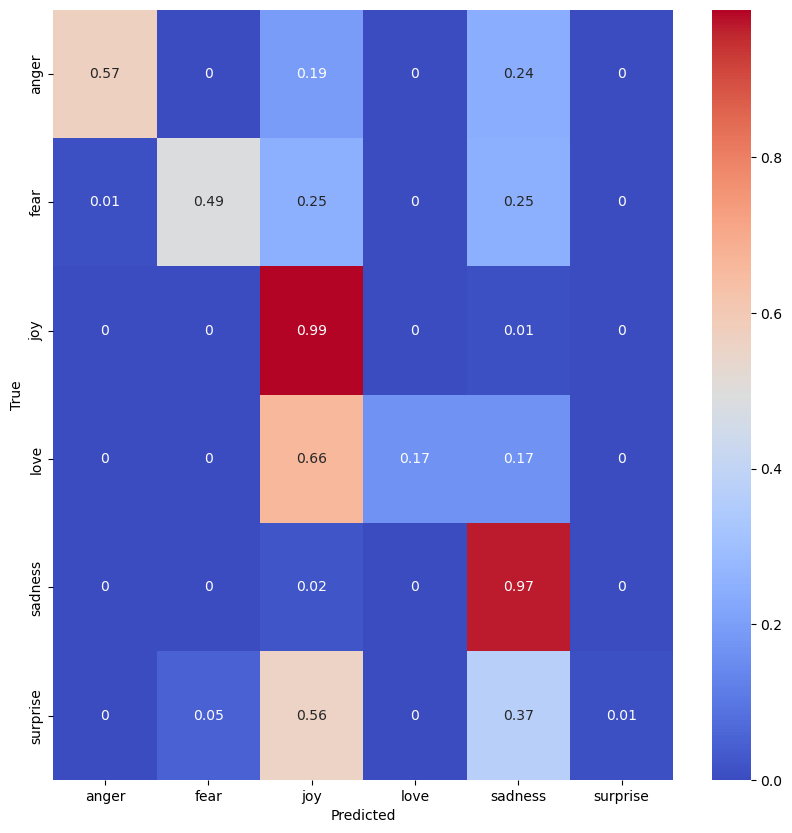

Val confusion matrix


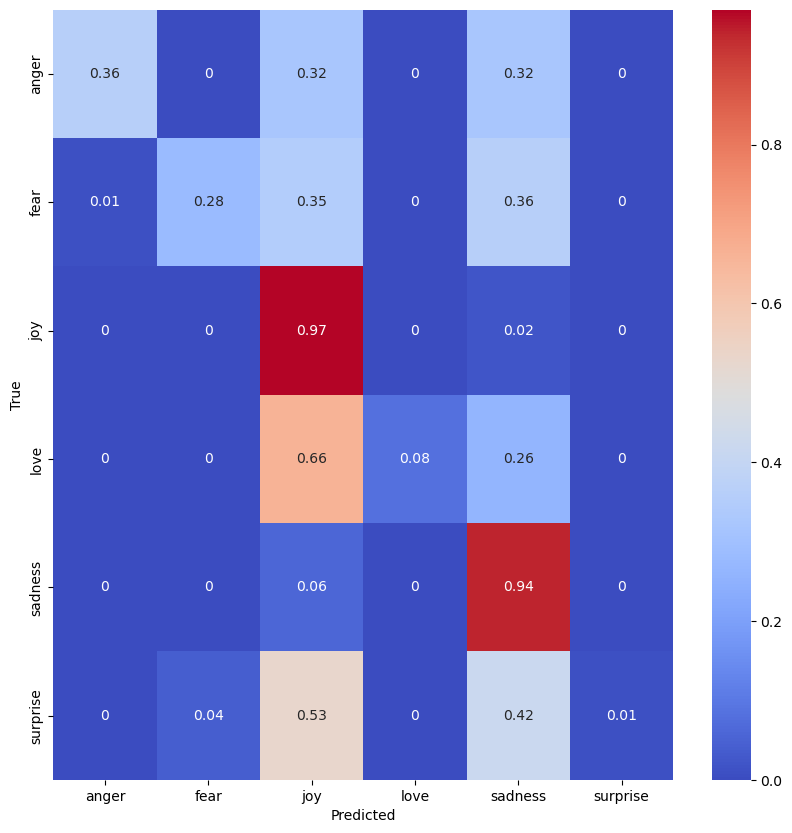

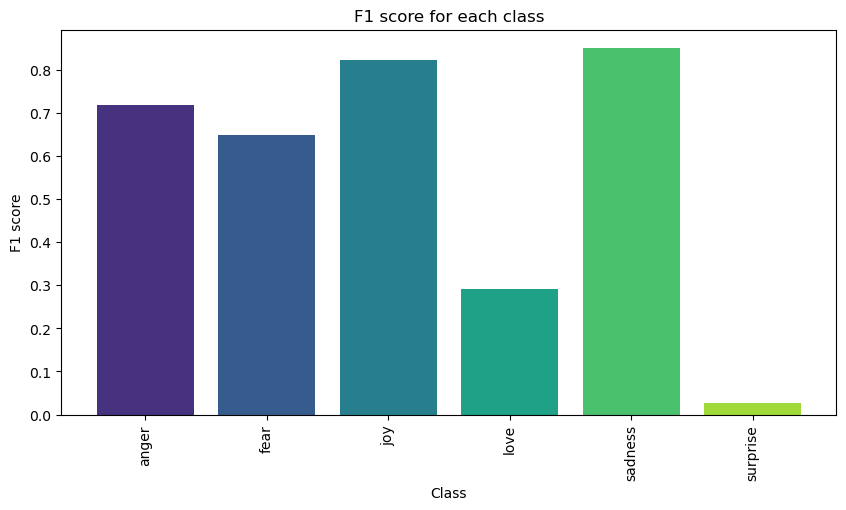

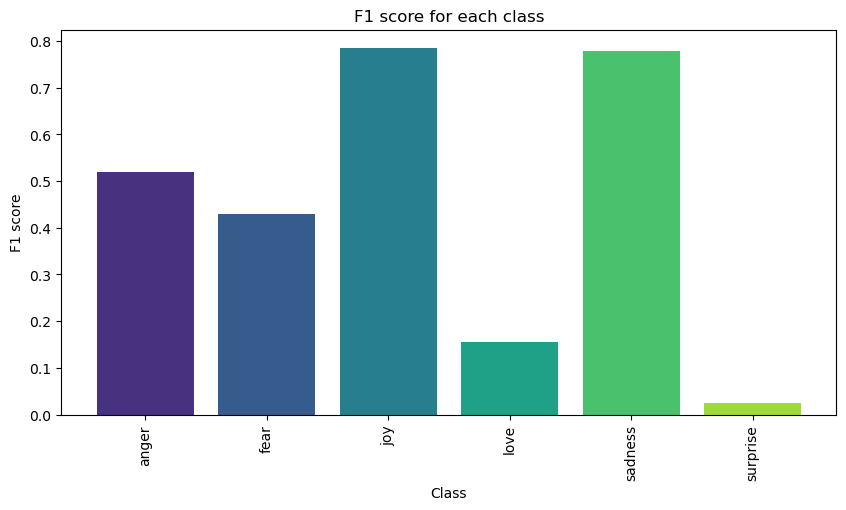

In [6]:
# create classifier
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', MultinomialNB())
])

sl_bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
              precision    recall  f1-score   support

       anger       0.97      0.63      0.76      2159
        fear       0.96      0.54      0.69      1937
         joy       0.78      0.98      0.87      5362
        love       0.97      0.25      0.40      1304
     sadness       0.72      0.98      0.83      4666
    surprise       0.96      0.05      0.09       572

    accuracy                           0.79     16000
   macro avg       0.89      0.57      0.61     16000
weighted avg       0.83      0.79      0.76     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.93      0.36      0.52       275
        fear       0.87      0.32      0.46       212
         joy       0.71      0.94      0.81       704
        love       0.86      0.07      0.12       178
     sadness       0.61      0.95      0.74       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.68      20

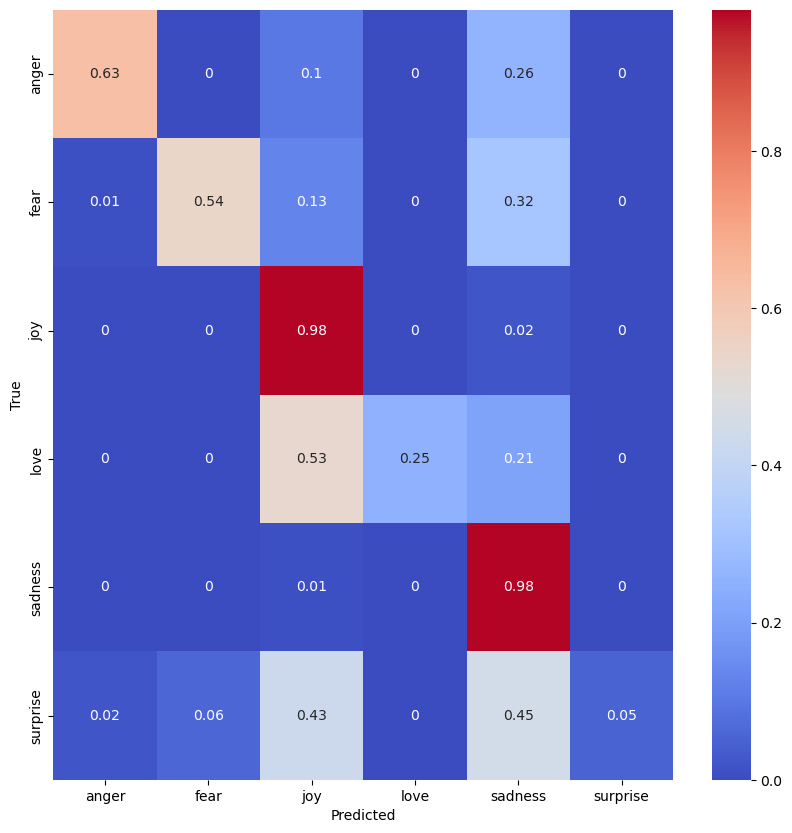

Val confusion matrix


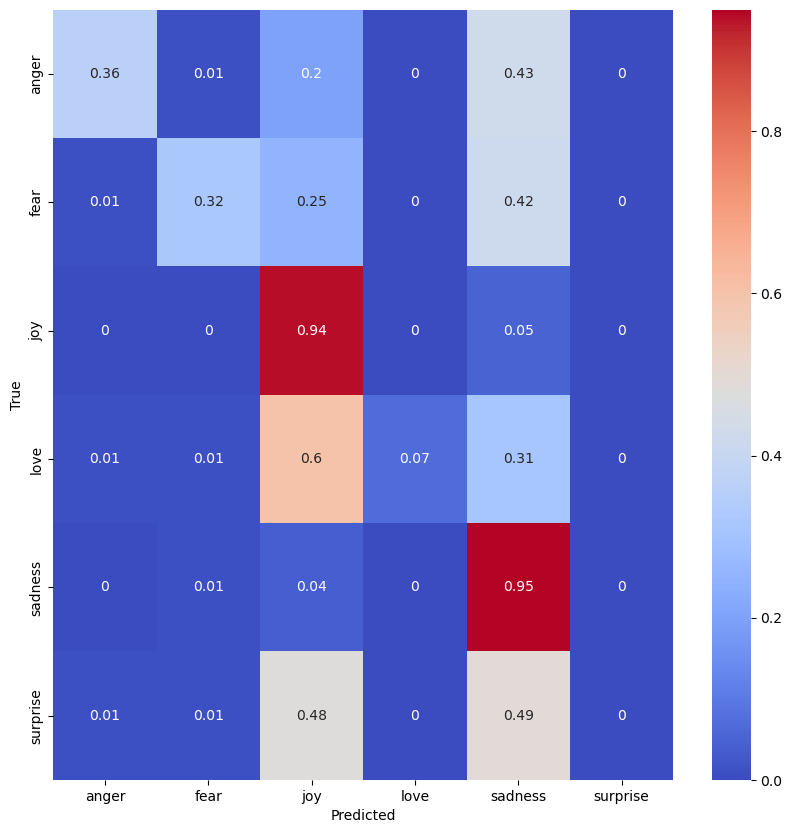

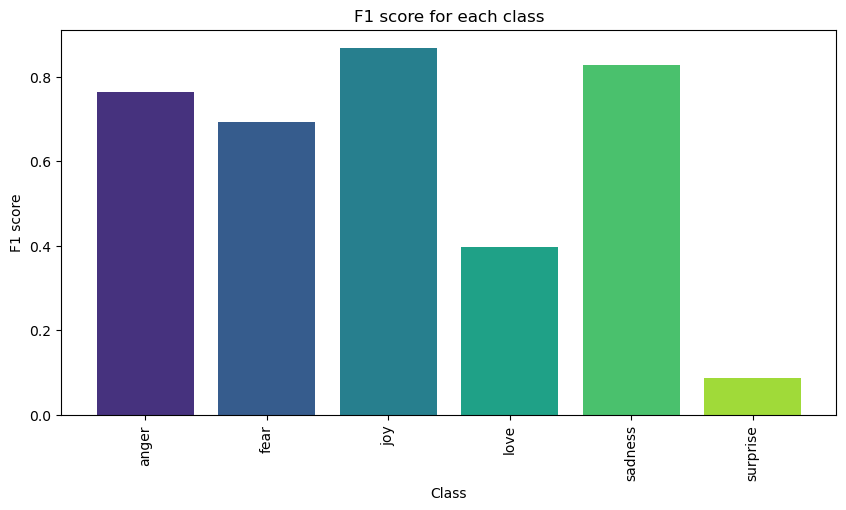

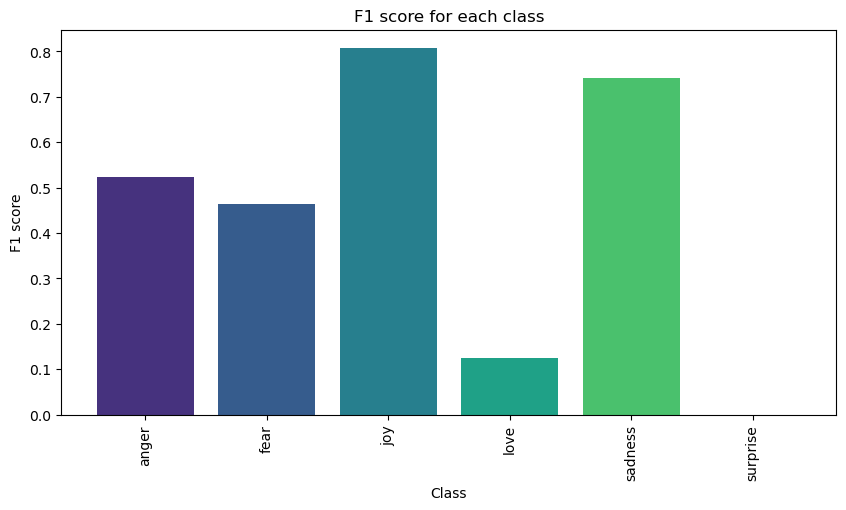

In [7]:
# create classifier
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', BernoulliNB())
])

sl_bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
              precision    recall  f1-score   support

       anger       0.97      0.62      0.76      2159
        fear       0.96      0.55      0.70      1937
         joy       0.80      0.98      0.88      5362
        love       0.96      0.28      0.44      1304
     sadness       0.70      0.99      0.82      4666
    surprise       0.94      0.05      0.10       572

    accuracy                           0.79     16000
   macro avg       0.89      0.58      0.62     16000
weighted avg       0.83      0.79      0.76     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.90      0.39      0.54       275
        fear       0.85      0.36      0.50       212
         joy       0.73      0.93      0.82       704
        love       0.85      0.10      0.17       178
     sadness       0.60      0.95      0.73       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.69      20

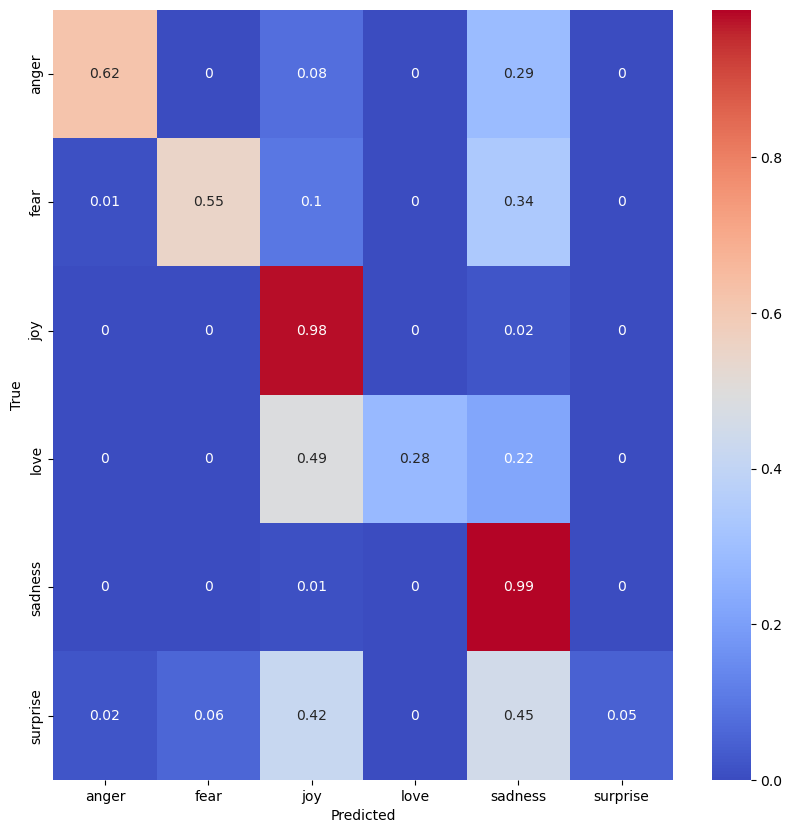

Val confusion matrix


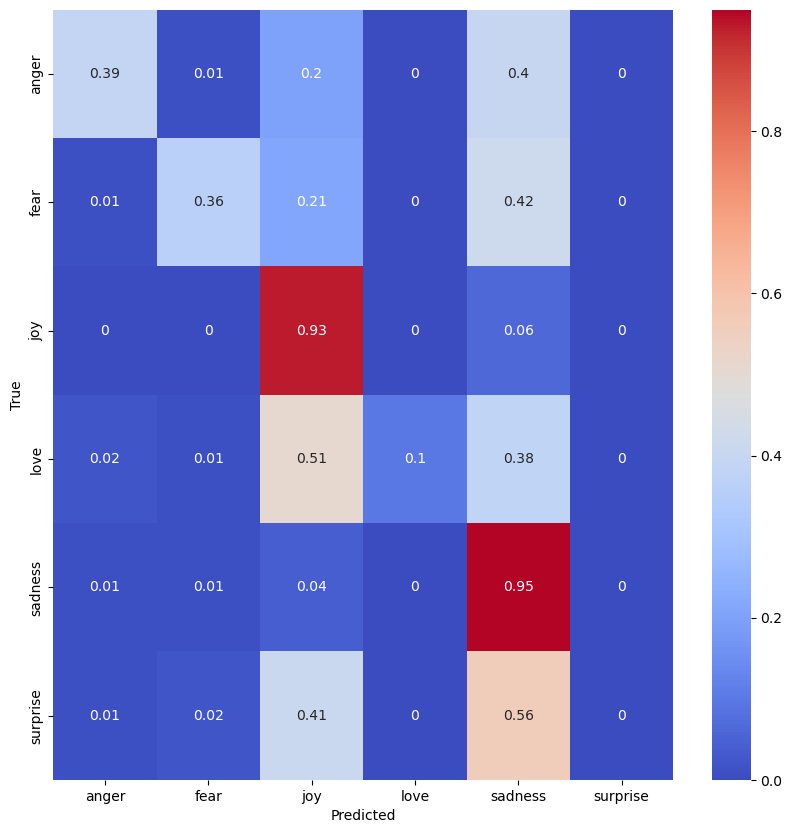

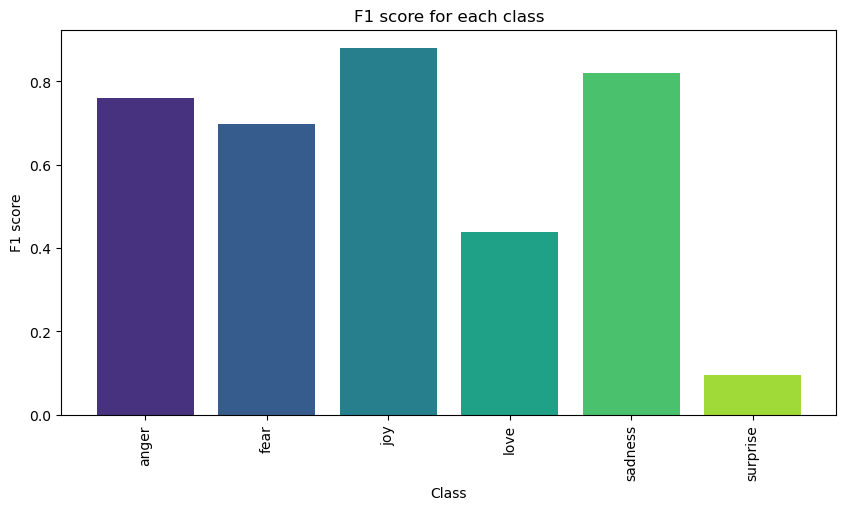

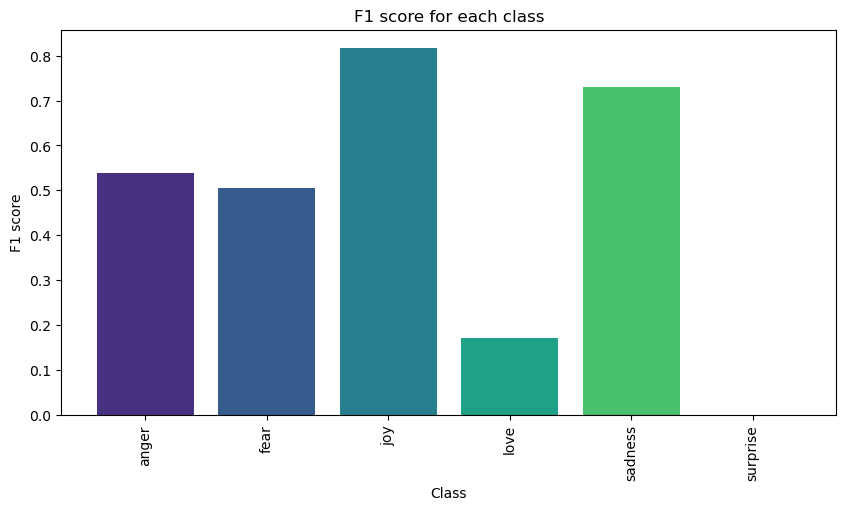

In [8]:
# create classifier
classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', BernoulliNB())
])

sl_bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
              precision    recall  f1-score   support

       anger       0.97      0.63      0.76      2159
        fear       0.96      0.54      0.69      1937
         joy       0.78      0.98      0.87      5362
        love       0.97      0.25      0.40      1304
     sadness       0.72      0.98      0.83      4666
    surprise       0.96      0.05      0.09       572

    accuracy                           0.79     16000
   macro avg       0.89      0.57      0.61     16000
weighted avg       0.83      0.79      0.76     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.93      0.36      0.52       275
        fear       0.87      0.32      0.46       212
         joy       0.71      0.94      0.81       704
        love       0.86      0.07      0.12       178
     sadness       0.61      0.95      0.74       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.68      20

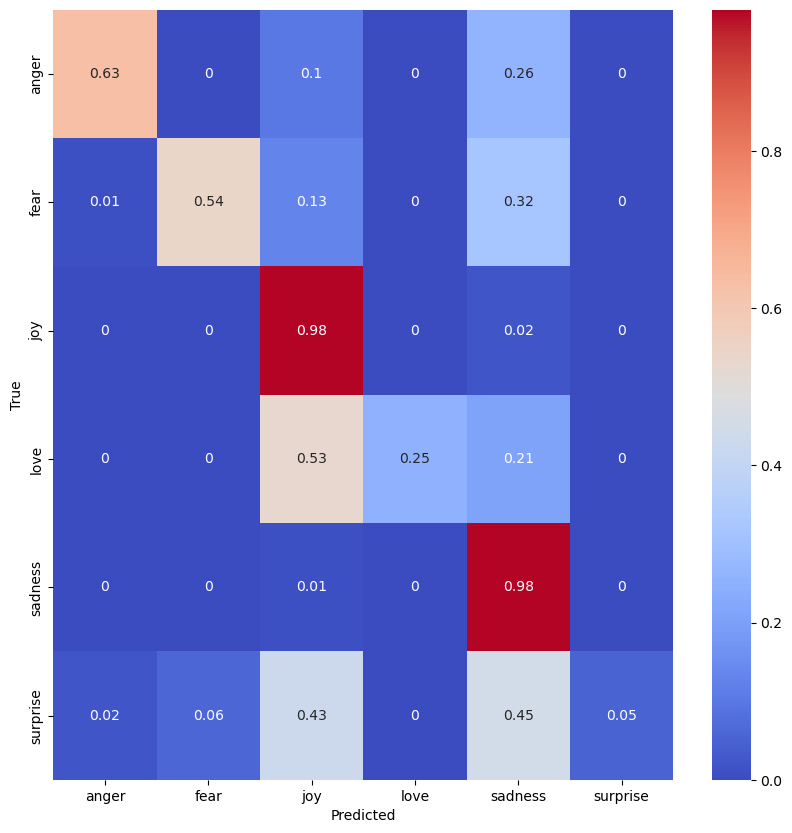

Val confusion matrix


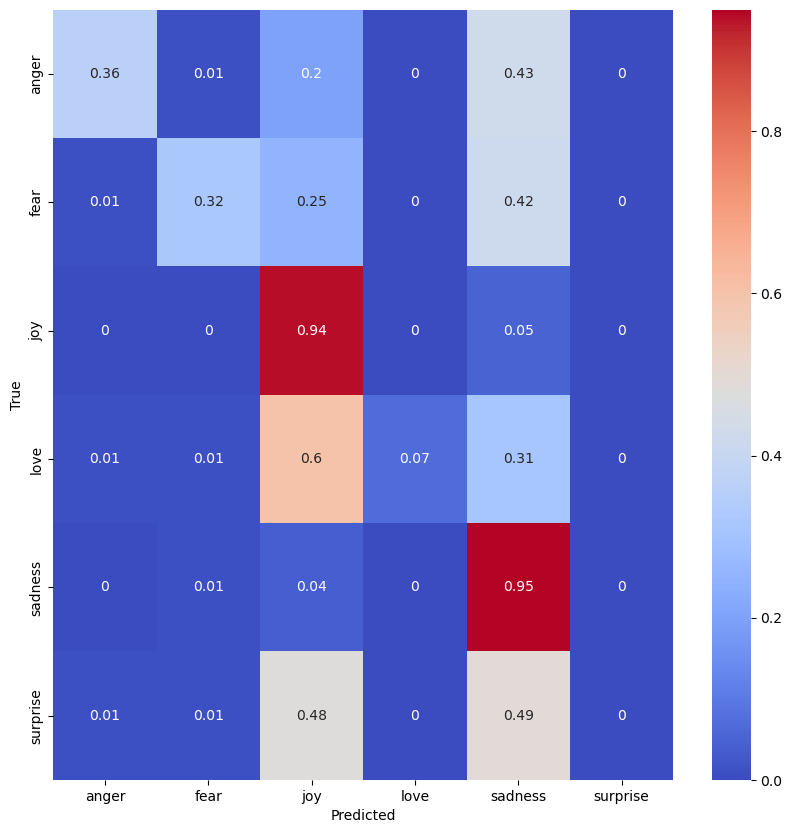

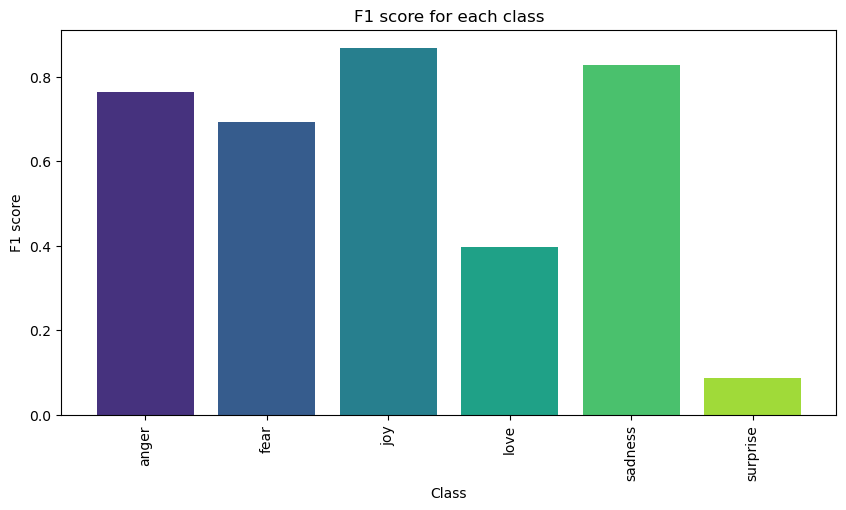

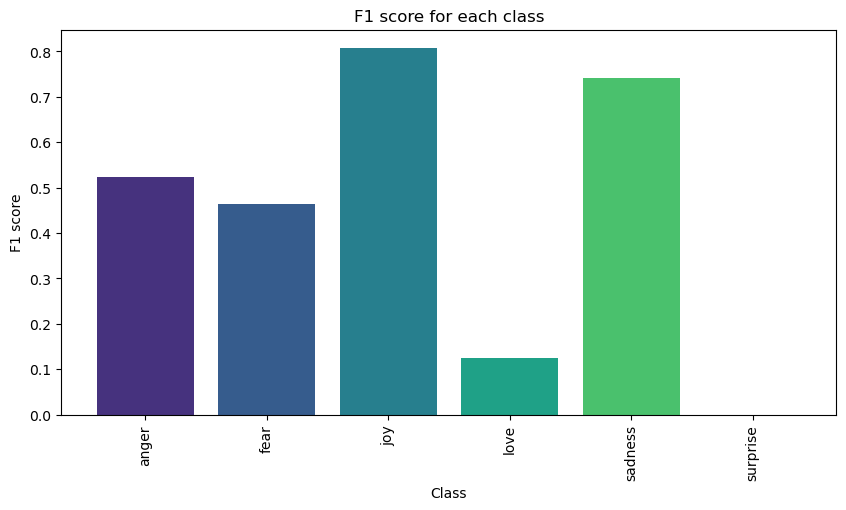

In [9]:
# create classifier
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('classifier', BernoulliNB())
])

sl_bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

removing stopwords yealds worse results

## OVA Bayes

In [8]:
def bayes_analysis(train_df, val_df, classifier, text_col, label_cols):
    # train classifier
    classifier.fit(train_df[text_col], train_df[label_cols])
    # predict
    predictions_train = classifier.predict(train_df[text_col])
    predictions_val = classifier.predict(val_df[text_col])
    # calculate metrics
    print("Train metrics")
    print(classification_report(train_df[label_cols], predictions_train, target_names=label_cols, zero_division=0))
    print("Val metrics")
    print(classification_report(val_df[label_cols], predictions_val, target_names=label_cols, zero_division=0))
    # plot confusion matrix
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), predictions_train, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), predictions_val, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], predictions_val, label_cols)

In [11]:
# training one versus rest classifier
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
]))

Train metrics
              precision    recall  f1-score   support

       anger       0.99      0.07      0.14      2159
        fear       0.98      0.05      0.10      1937
         joy       0.99      0.59      0.74      5362
        love       0.96      0.02      0.04      1304
     sadness       1.00      0.46      0.63      4666
    surprise       1.00      0.00      0.00       572

   micro avg       0.99      0.35      0.52     16000
   macro avg       0.99      0.20      0.27     16000
weighted avg       0.99      0.35      0.47     16000
 samples avg       0.35      0.35      0.35     16000

Val metrics
              precision    recall  f1-score   support

       anger       1.00      0.03      0.06       275
        fear       1.00      0.05      0.09       212
         joy       0.99      0.38      0.55       704
        love       1.00      0.02      0.03       178
     sadness       0.99      0.32      0.48       550
    surprise       0.00      0.00      0.00        8

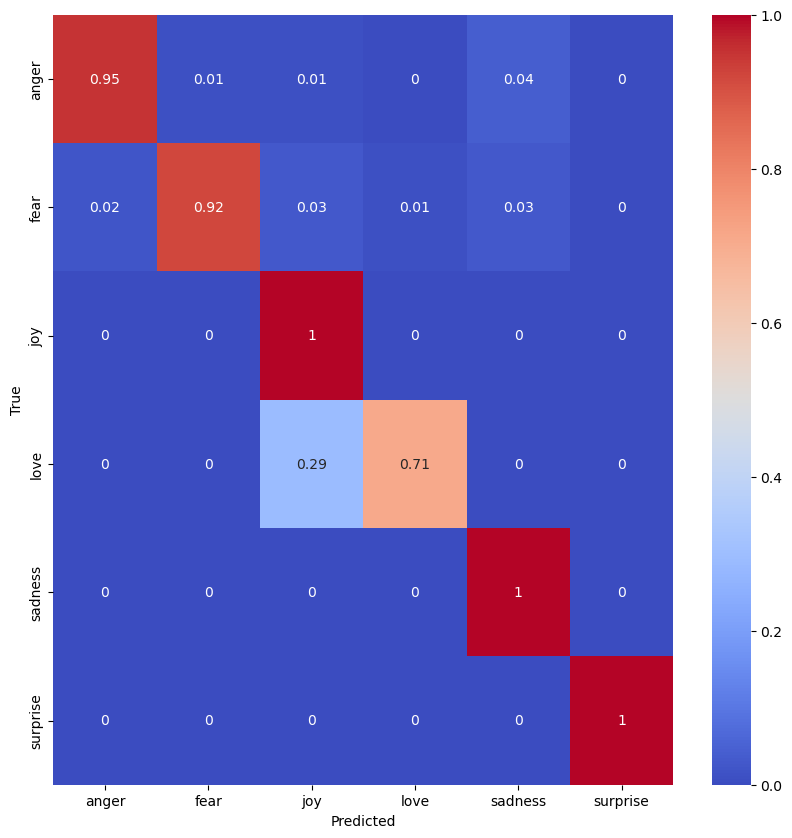

Val confusion matrix


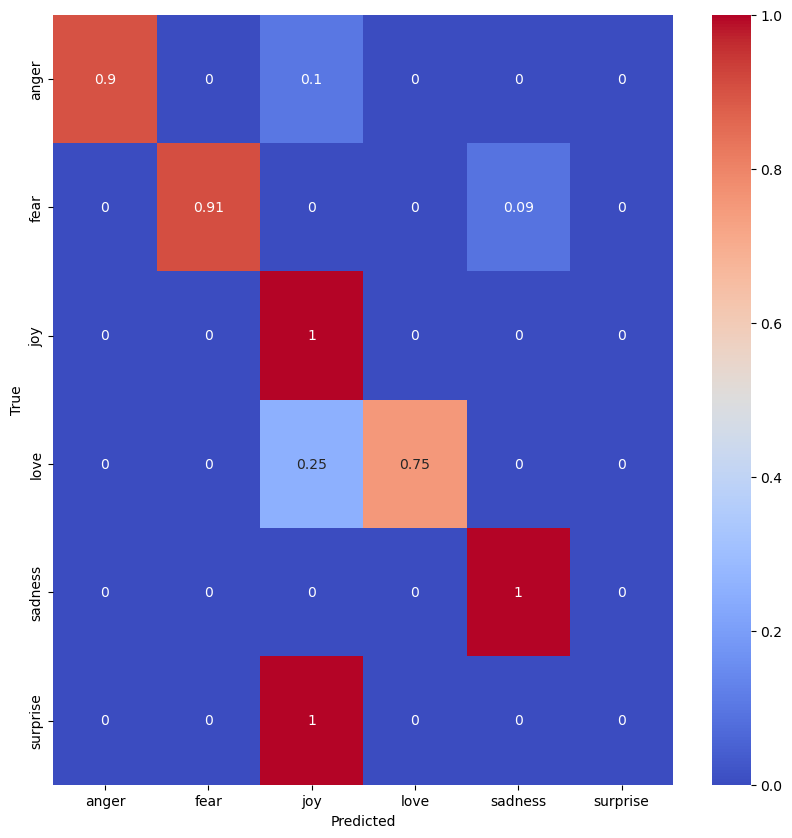

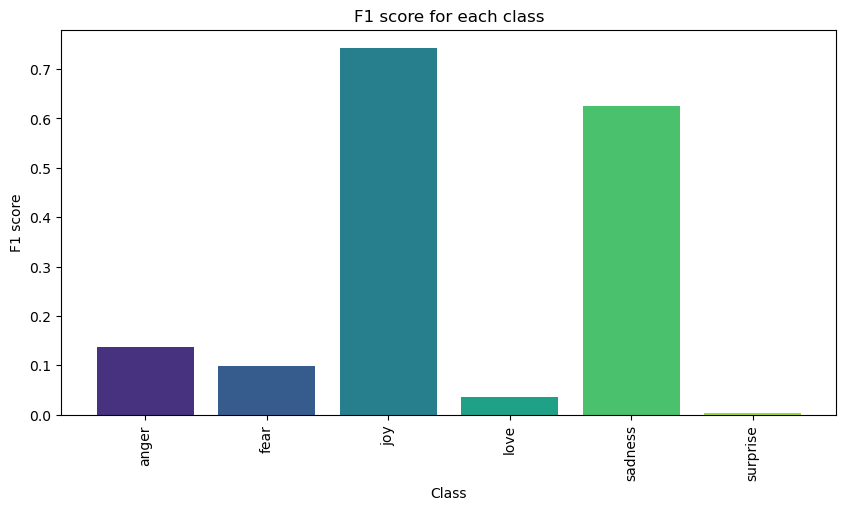

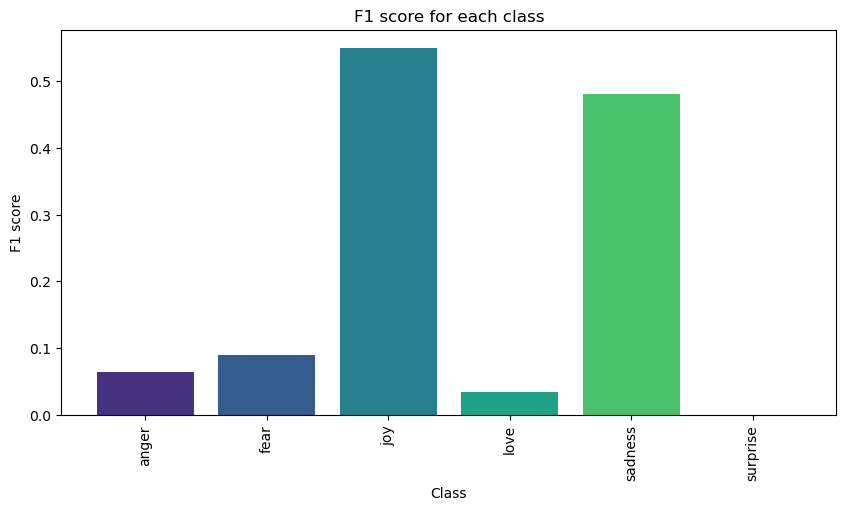

In [12]:
bayes_analysis(train_df, val_df, NB_classifier, TEXT_COLUMN, LABELS)

## Testing Bayes with normalized text

Train metrics
              precision    recall  f1-score   support

       anger       1.00      0.19      0.32      2159
        fear       0.99      0.15      0.25      1937
         joy       0.99      0.74      0.85      5362
        love       0.98      0.05      0.09      1304
     sadness       0.99      0.66      0.79      4666
    surprise       0.80      0.01      0.01       572

   micro avg       0.99      0.49      0.65     16000
   macro avg       0.96      0.30      0.39     16000
weighted avg       0.99      0.49      0.60     16000
 samples avg       0.49      0.49      0.49     16000

Val metrics
              precision    recall  f1-score   support

       anger       1.00      0.08      0.15       275
        fear       1.00      0.09      0.17       212
         joy       0.98      0.56      0.71       704
        love       1.00      0.02      0.04       178
     sadness       0.99      0.49      0.65       550
    surprise       0.00      0.00      0.00        8

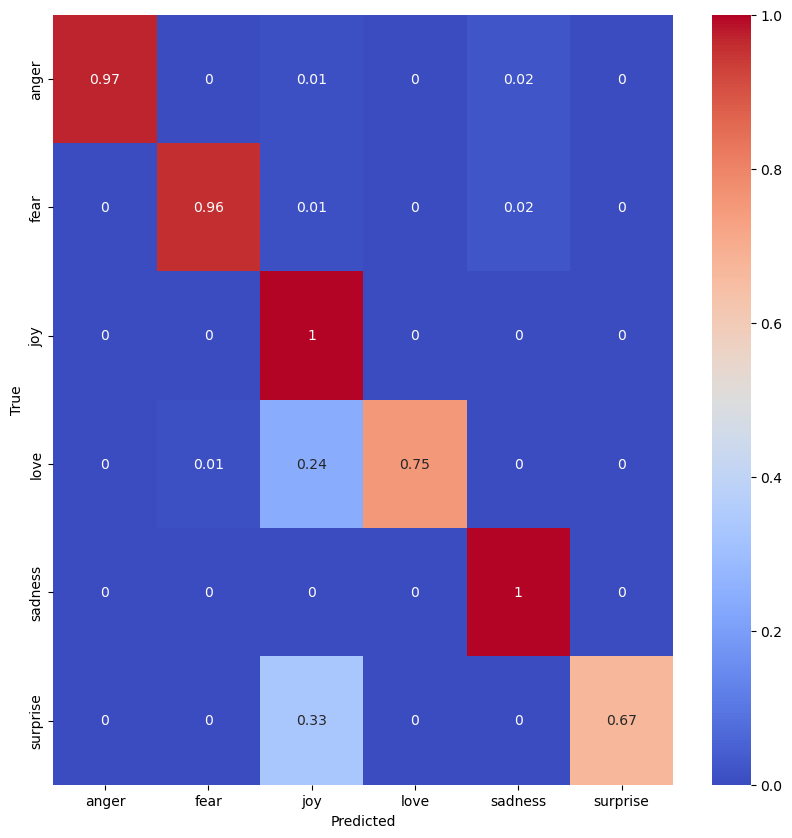

Val confusion matrix


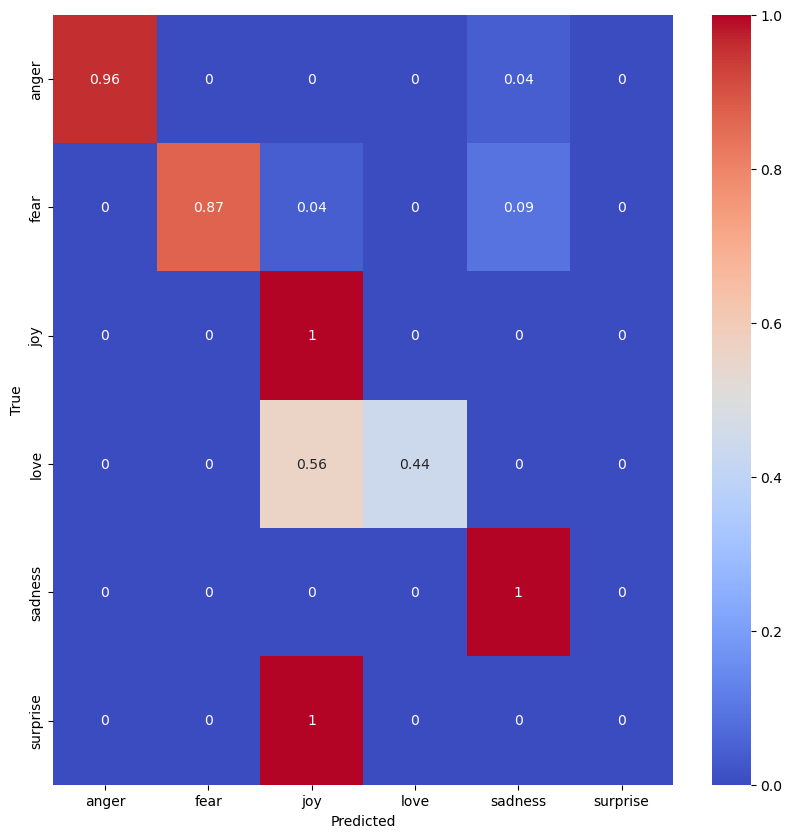

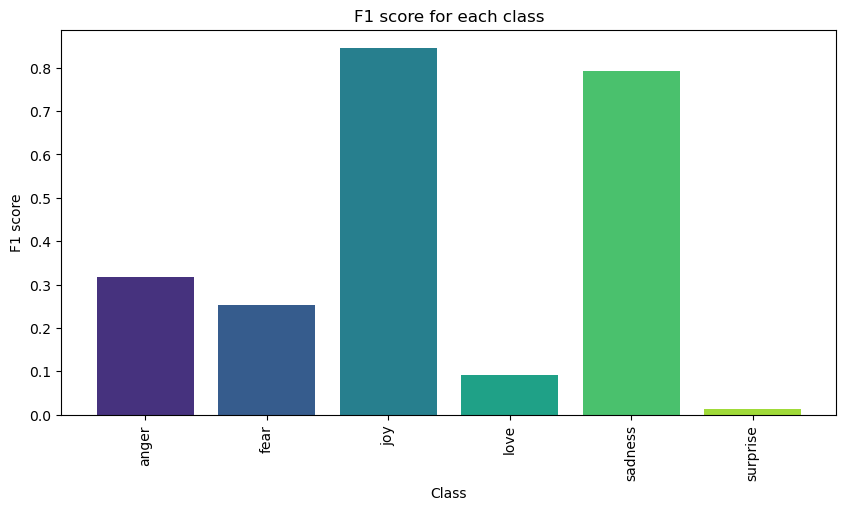

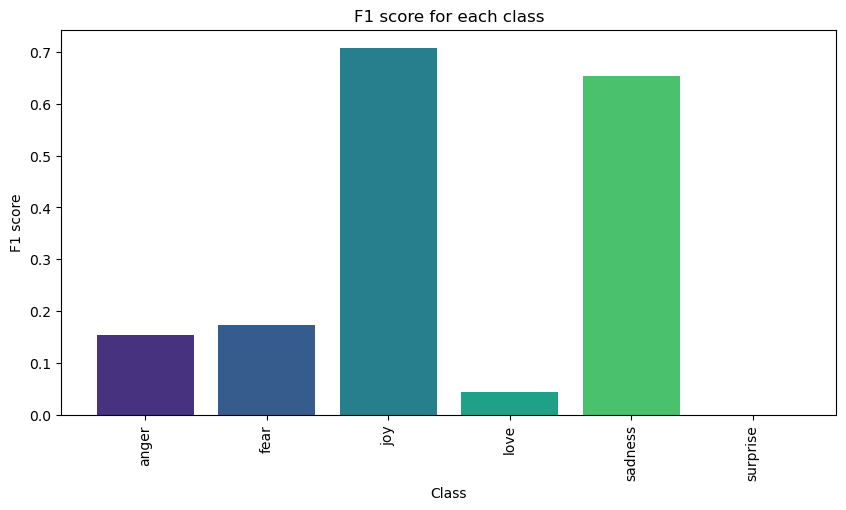

In [13]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

## Test add k

Train metrics
              precision    recall  f1-score   support

       anger       0.99      0.77      0.87      2159
        fear       0.99      0.69      0.82      1937
         joy       0.98      0.90      0.94      5362
        love       0.99      0.62      0.76      1304
     sadness       0.99      0.91      0.95      4666
    surprise       0.99      0.46      0.63       572

   micro avg       0.99      0.82      0.90     16000
   macro avg       0.99      0.72      0.83     16000
weighted avg       0.99      0.82      0.89     16000
 samples avg       0.82      0.82      0.82     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.94      0.38      0.54       275
        fear       0.89      0.39      0.54       212
         joy       0.92      0.71      0.80       704
        love       0.92      0.20      0.33       178
     sadness       0.92      0.67      0.77       550
    surprise       1.00      0.12      0.22        8

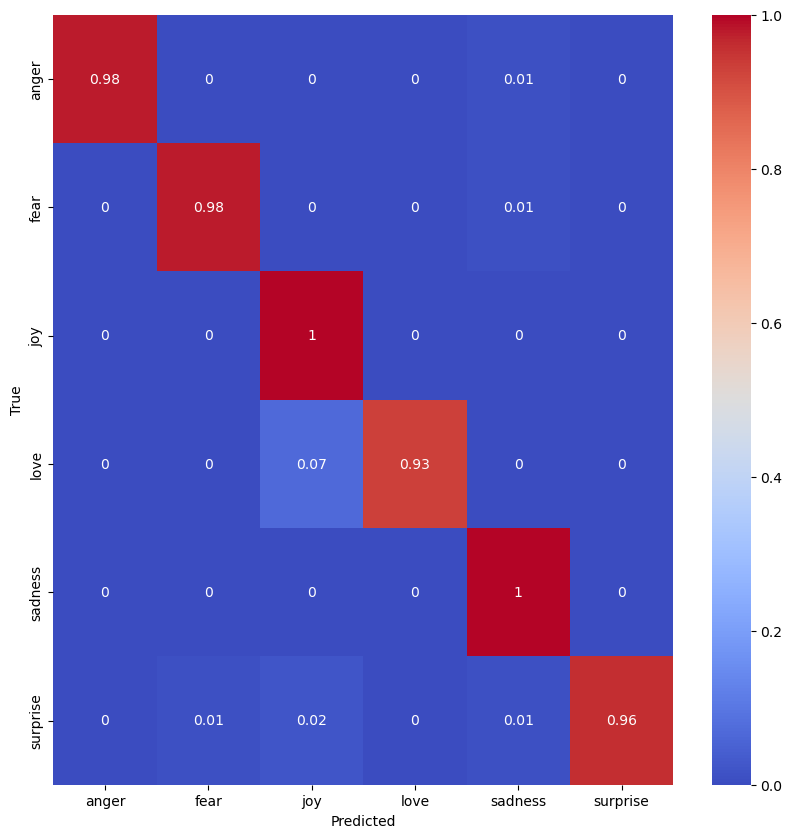

Val confusion matrix


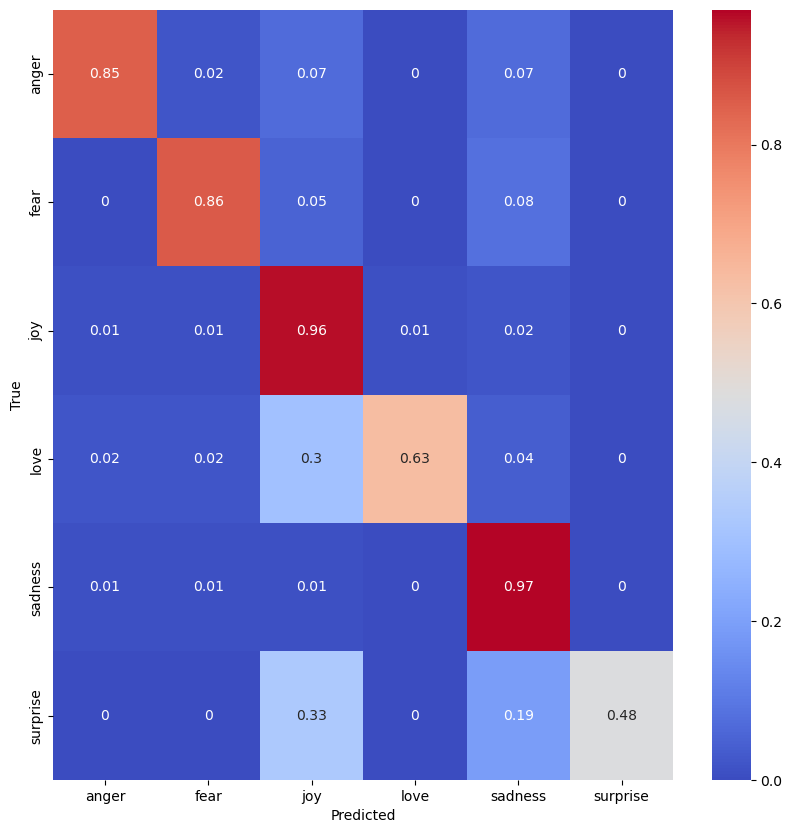

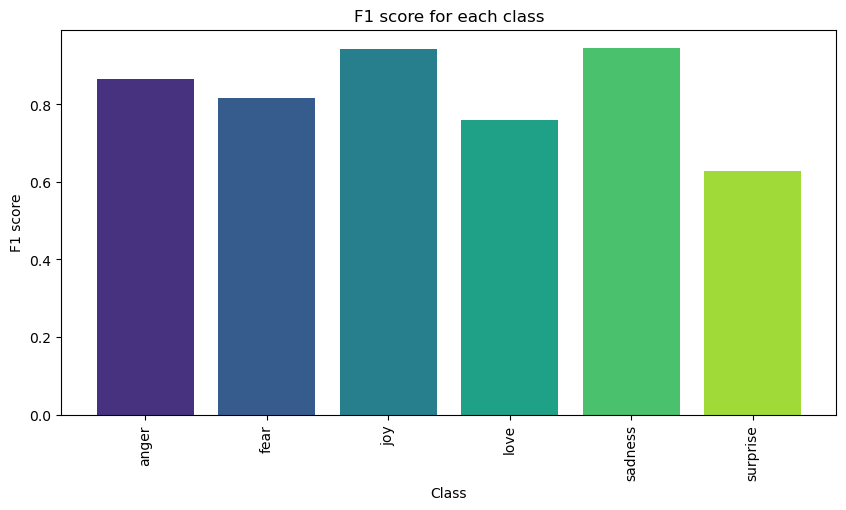

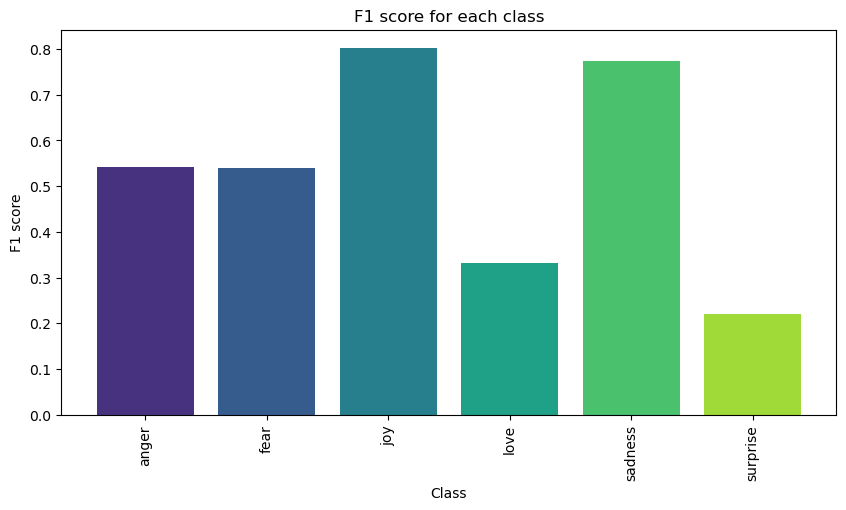

In [14]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB(alpha=0.1))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Add one smoothing is too much, decreasing it offered an improvement of performances

Train metrics
              precision    recall  f1-score   support

       anger       0.96      0.96      0.96      2159
        fear       0.94      0.95      0.94      1937
         joy       0.97      0.95      0.96      5362
        love       0.94      0.93      0.94      1304
     sadness       0.96      0.97      0.96      4666
    surprise       0.95      0.92      0.93       572

   micro avg       0.96      0.95      0.96     16000
   macro avg       0.95      0.95      0.95     16000
weighted avg       0.96      0.95      0.96     16000
 samples avg       0.94      0.95      0.94     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.84      0.61      0.71       275
        fear       0.74      0.60      0.66       212
         joy       0.88      0.76      0.81       704
        love       0.83      0.48      0.61       178
     sadness       0.83      0.75      0.79       550
    surprise       0.88      0.35      0.50        8

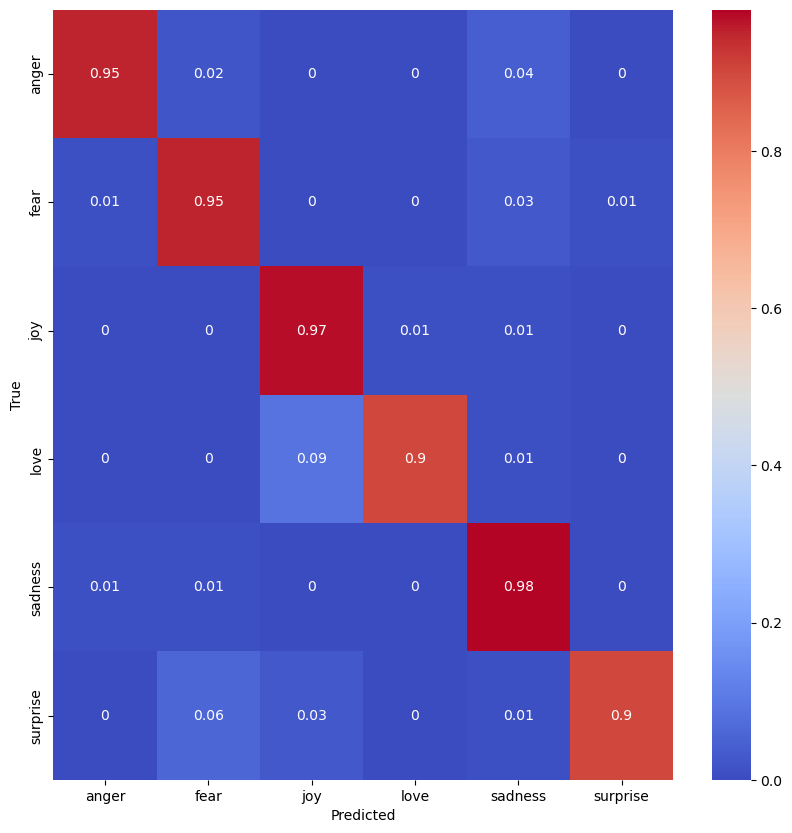

Val confusion matrix


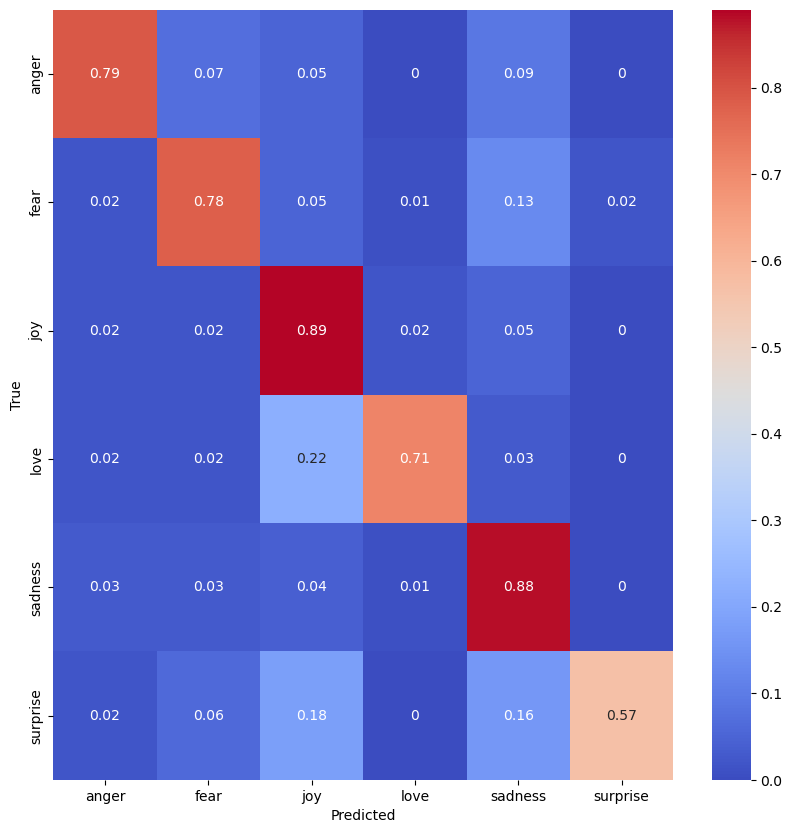

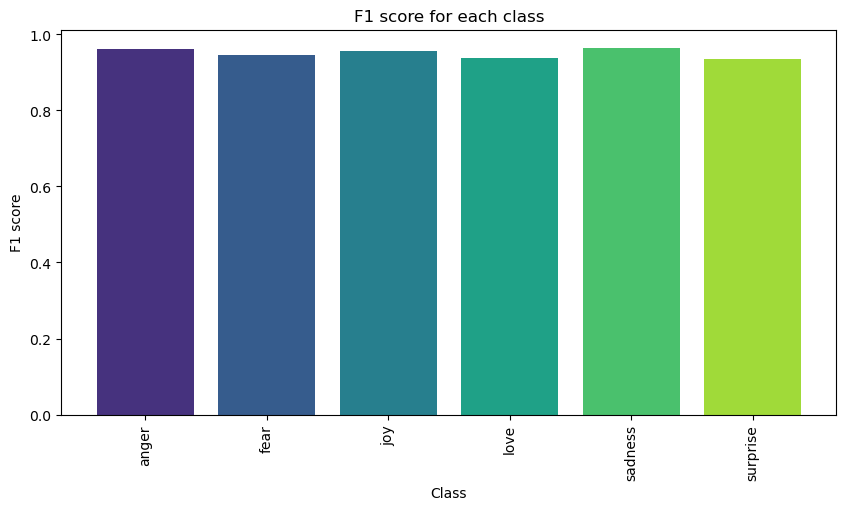

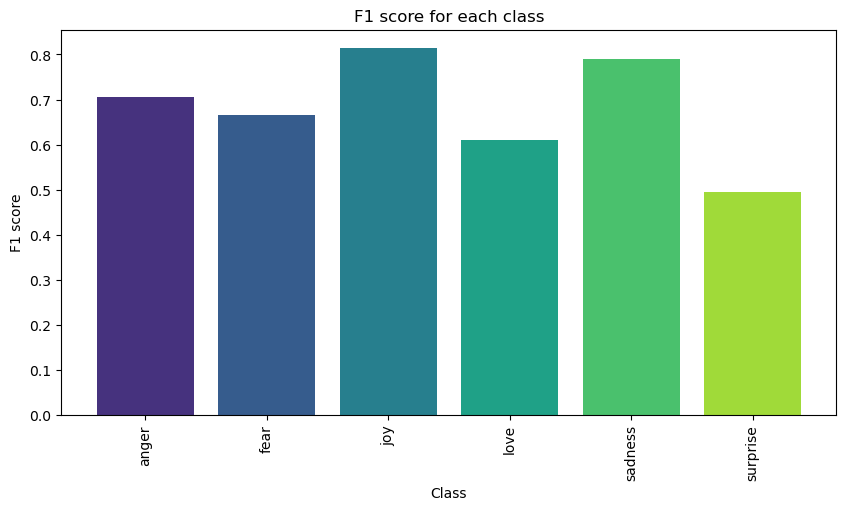

In [15]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', BernoulliNB(alpha=0.01))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Removing stopwords yealds better performances

Train metrics
              precision    recall  f1-score   support

       anger       0.96      0.96      0.96      2159
        fear       0.94      0.96      0.95      1937
         joy       0.97      0.94      0.95      5362
        love       0.93      0.92      0.93      1304
     sadness       0.95      0.98      0.97      4666
    surprise       0.96      0.92      0.94       572

   micro avg       0.95      0.96      0.96     16000
   macro avg       0.95      0.95      0.95     16000
weighted avg       0.95      0.96      0.95     16000
 samples avg       0.94      0.96      0.95     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.83      0.60      0.69       275
        fear       0.74      0.60      0.66       212
         joy       0.87      0.76      0.81       704
        love       0.83      0.48      0.61       178
     sadness       0.81      0.74      0.77       550
    surprise       0.87      0.33      0.48        8

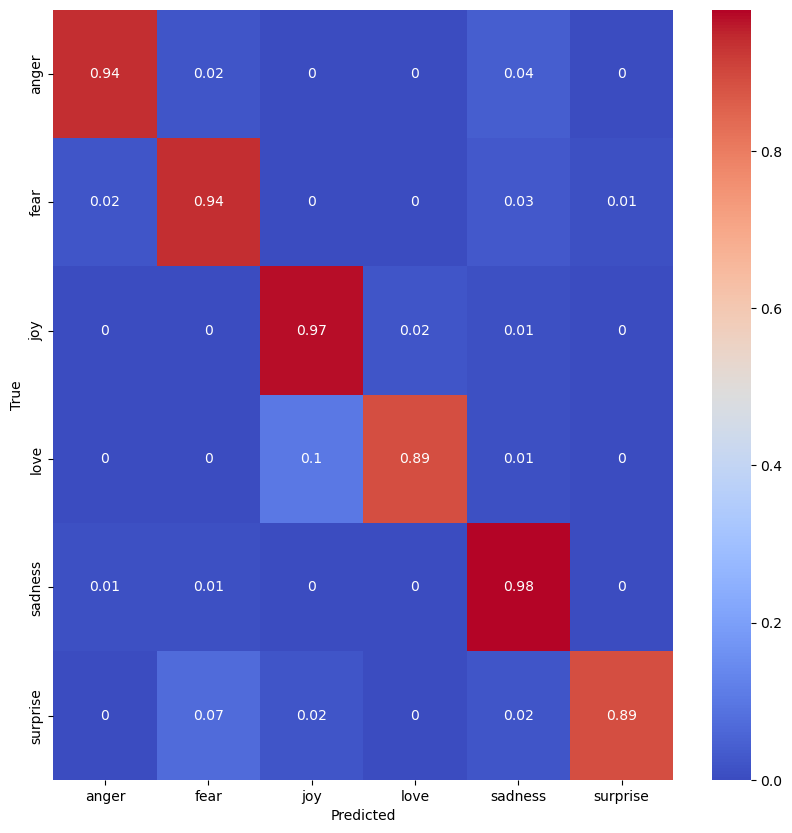

Val confusion matrix


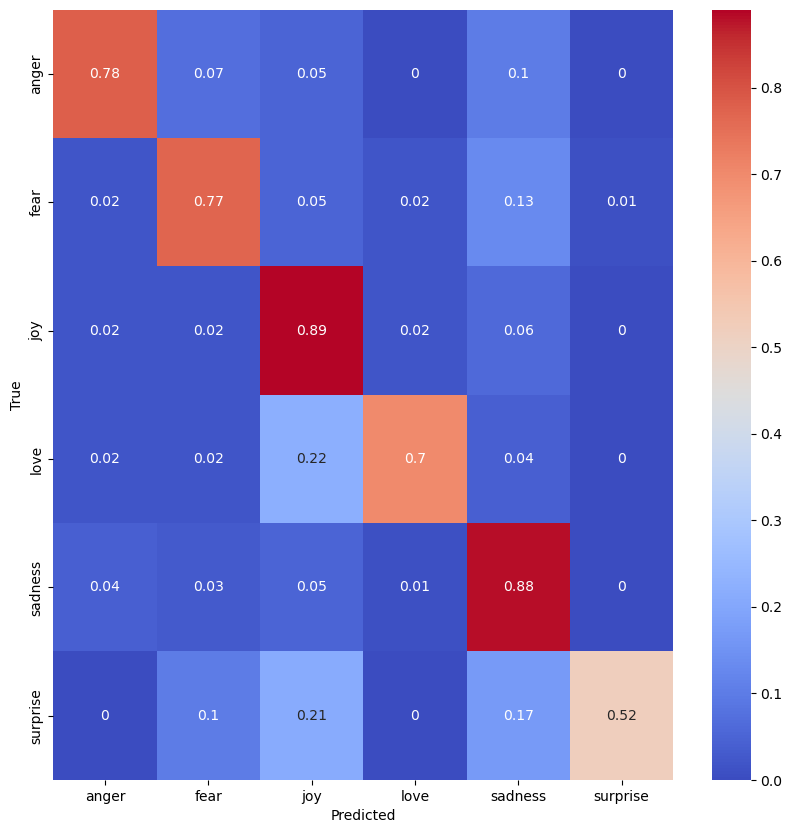

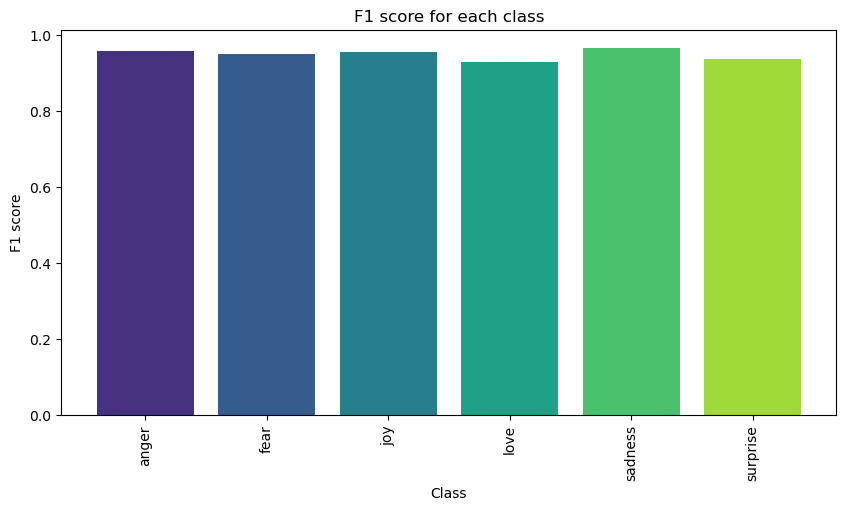

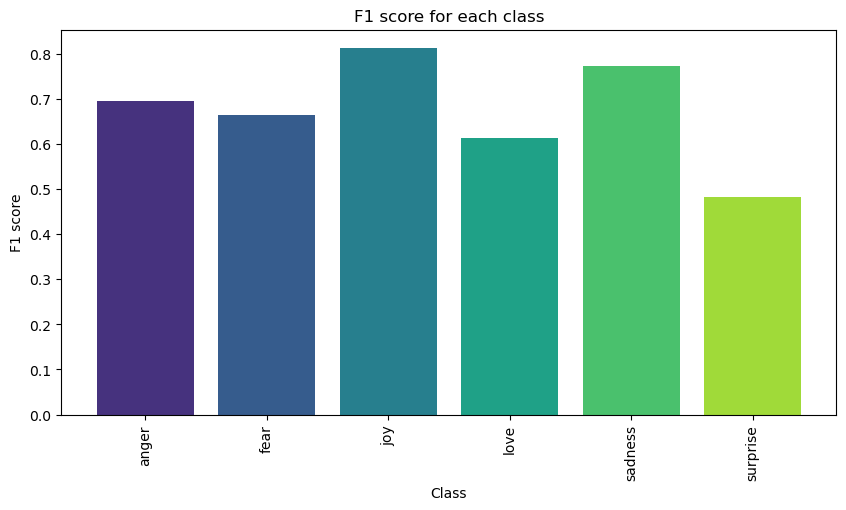

In [16]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', BernoulliNB(alpha=0.01))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

### Feature selection

Attempt with min df

Train metrics
              precision    recall  f1-score   support

       anger       0.93      0.86      0.89      2159
        fear       0.91      0.85      0.88      1937
         joy       0.92      0.88      0.90      5362
        love       0.85      0.75      0.79      1304
     sadness       0.94      0.90      0.92      4666
    surprise       0.88      0.83      0.85       572

   micro avg       0.92      0.87      0.89     16000
   macro avg       0.90      0.84      0.87     16000
weighted avg       0.92      0.87      0.89     16000
 samples avg       0.85      0.87      0.85     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.89      0.73      0.80       275
        fear       0.87      0.72      0.79       212
         joy       0.91      0.84      0.87       704
        love       0.83      0.58      0.68       178
     sadness       0.90      0.87      0.88       550
    surprise       0.78      0.49      0.61        8

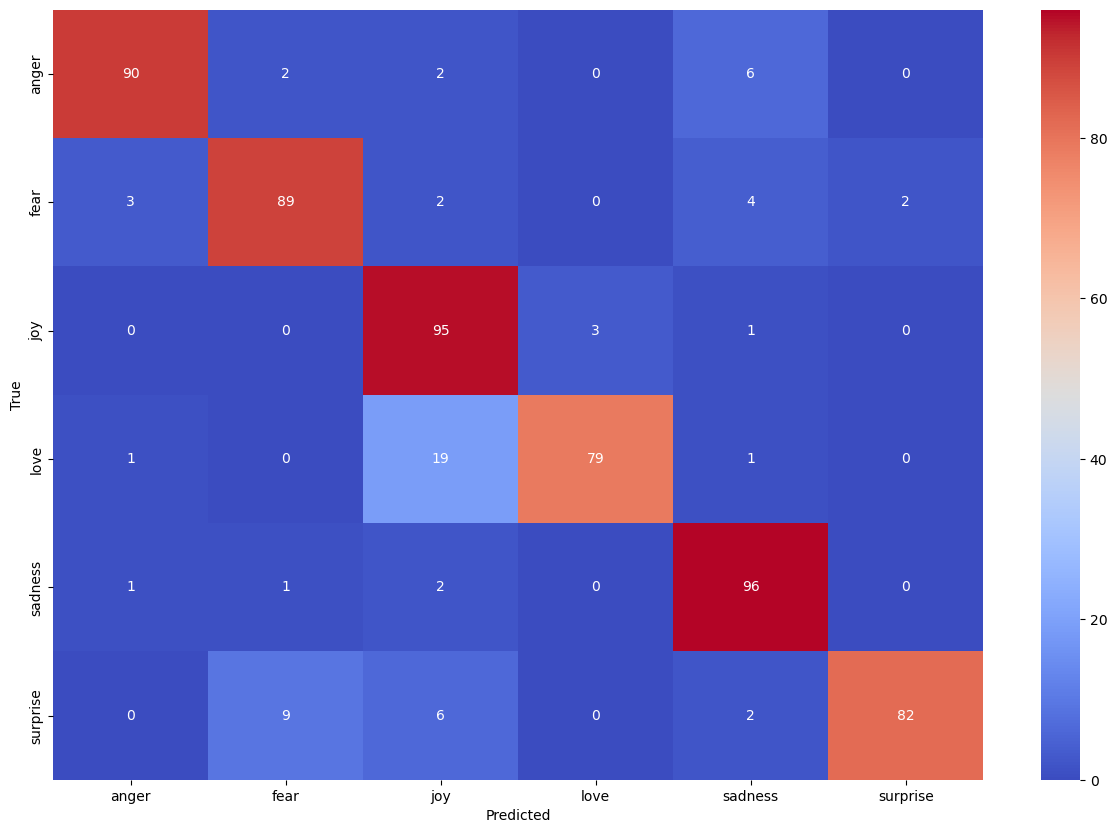

Val confusion matrix


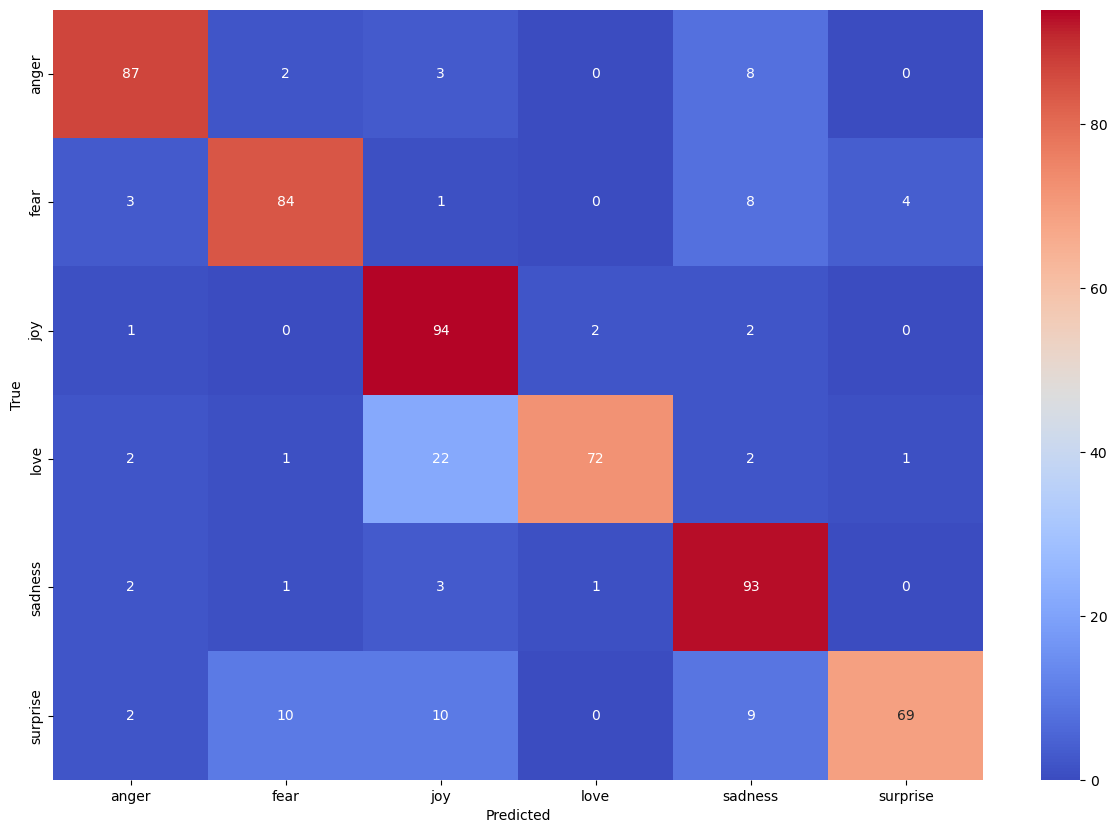

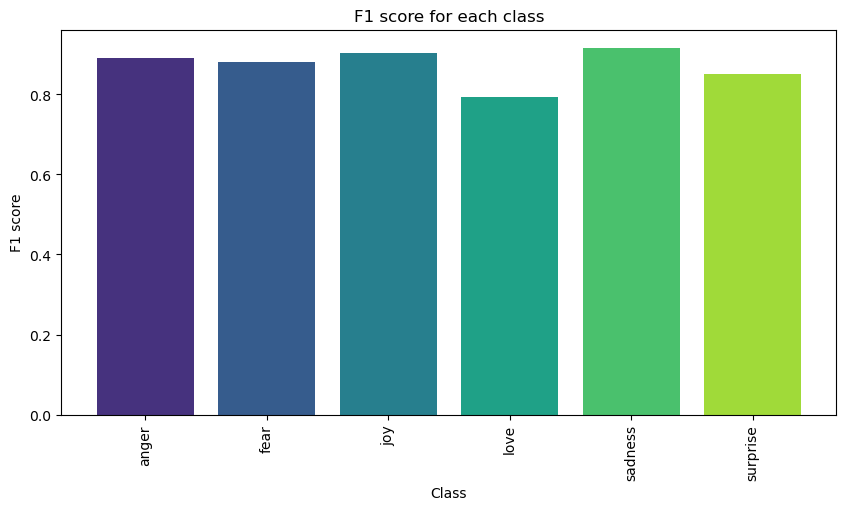

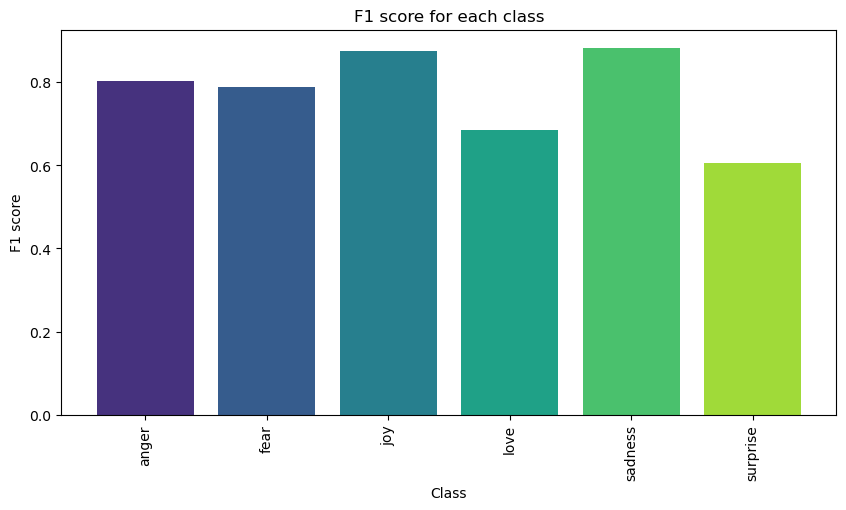

In [9]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10, stop_words='english')),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Attempt also with pmi based feature selection

Train metrics
              precision    recall  f1-score   support

       anger       0.93      0.88      0.91      2159
        fear       0.92      0.86      0.89      1937
         joy       0.93      0.90      0.92      5362
        love       0.86      0.76      0.81      1304
     sadness       0.94      0.92      0.93      4666
    surprise       0.89      0.84      0.87       572

   micro avg       0.93      0.88      0.91     16000
   macro avg       0.91      0.86      0.89     16000
weighted avg       0.93      0.88      0.90     16000
 samples avg       0.87      0.88      0.87     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.91      0.74      0.82       275
        fear       0.87      0.72      0.79       212
         joy       0.91      0.84      0.88       704
        love       0.82      0.60      0.69       178
     sadness       0.91      0.86      0.89       550
    surprise       0.84      0.58      0.69        8

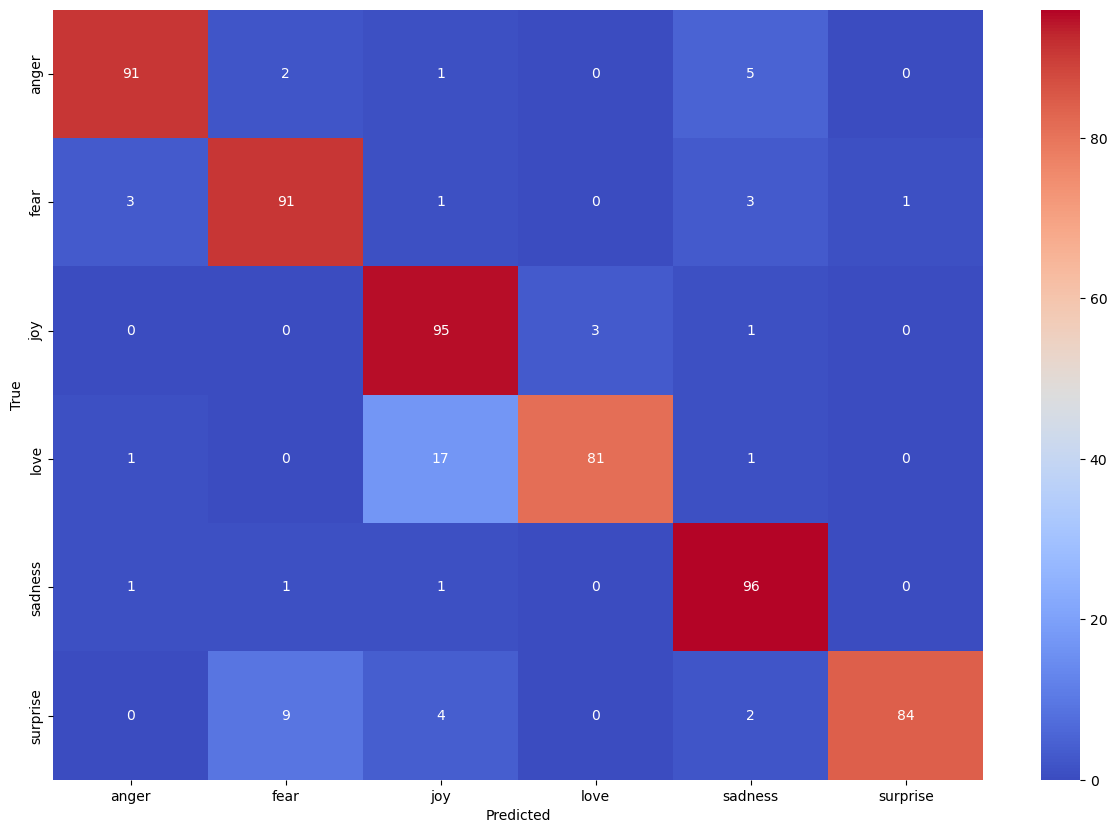

Val confusion matrix


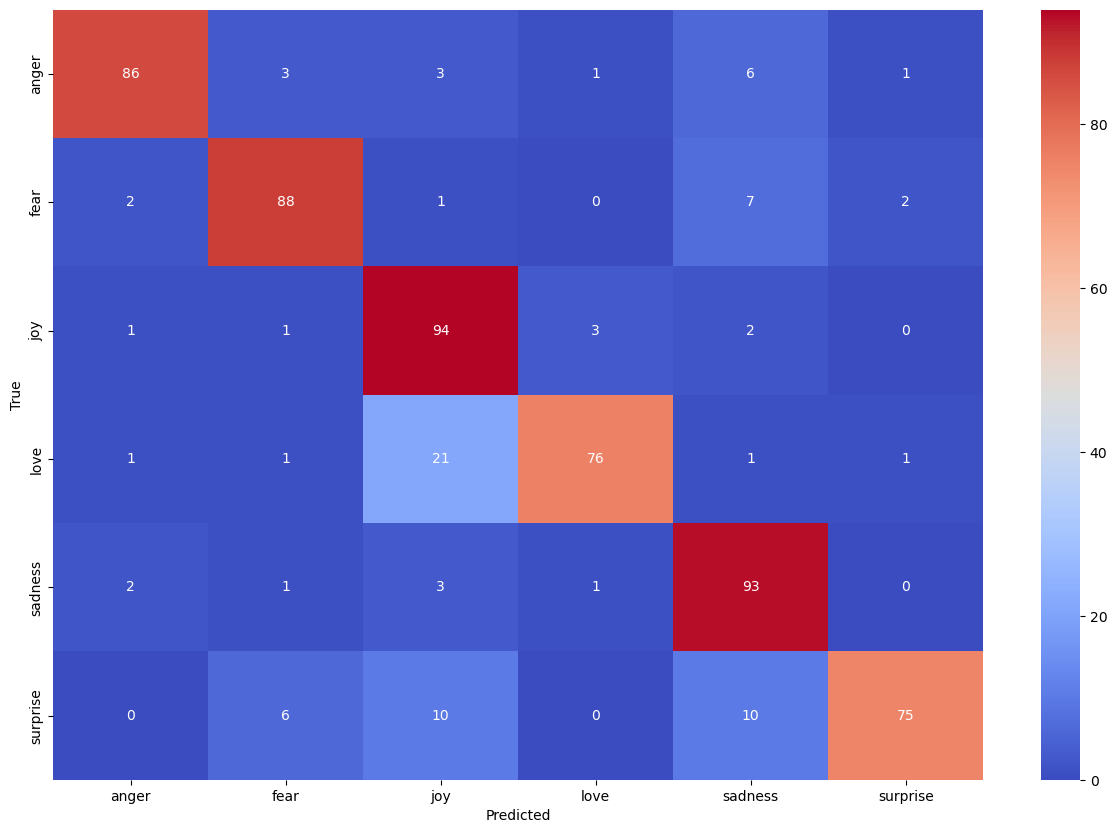

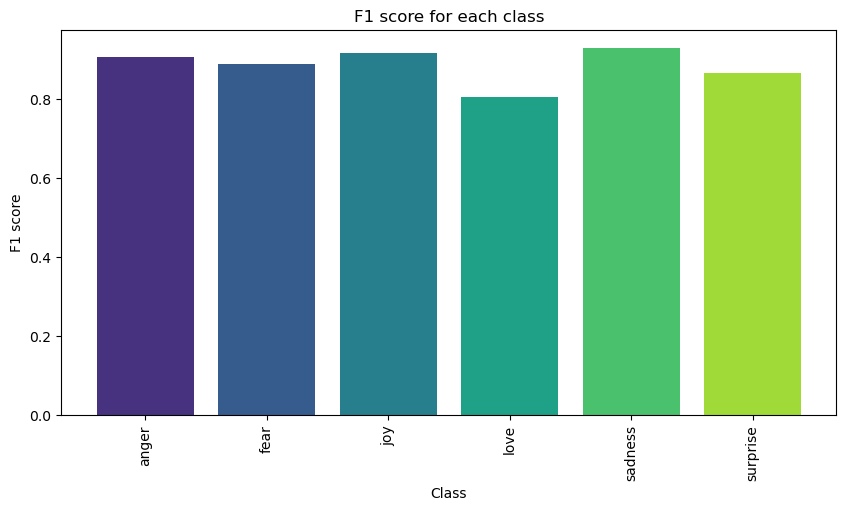

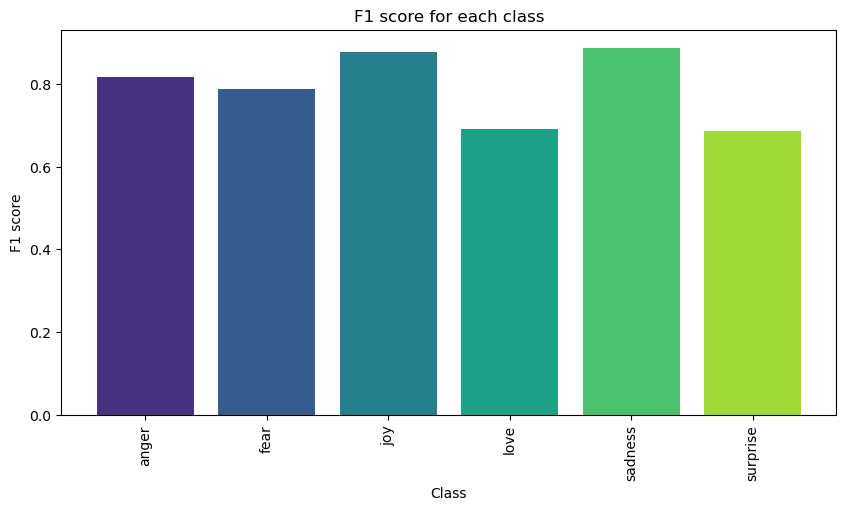

In [10]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
              precision    recall  f1-score   support

       anger       0.95      0.89      0.92      2159
        fear       0.94      0.88      0.91      1937
         joy       0.93      0.91      0.92      5362
        love       0.89      0.80      0.84      1304
     sadness       0.94      0.94      0.94      4666
    surprise       0.93      0.83      0.88       572

   micro avg       0.94      0.90      0.92     16000
   macro avg       0.93      0.87      0.90     16000
weighted avg       0.94      0.90      0.92     16000
 samples avg       0.88      0.90      0.89     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.83      0.71      0.76       275
        fear       0.78      0.68      0.73       212
         joy       0.89      0.82      0.85       704
        love       0.74      0.54      0.63       178
     sadness       0.87      0.85      0.86       550
    surprise       0.73      0.37      0.49        8

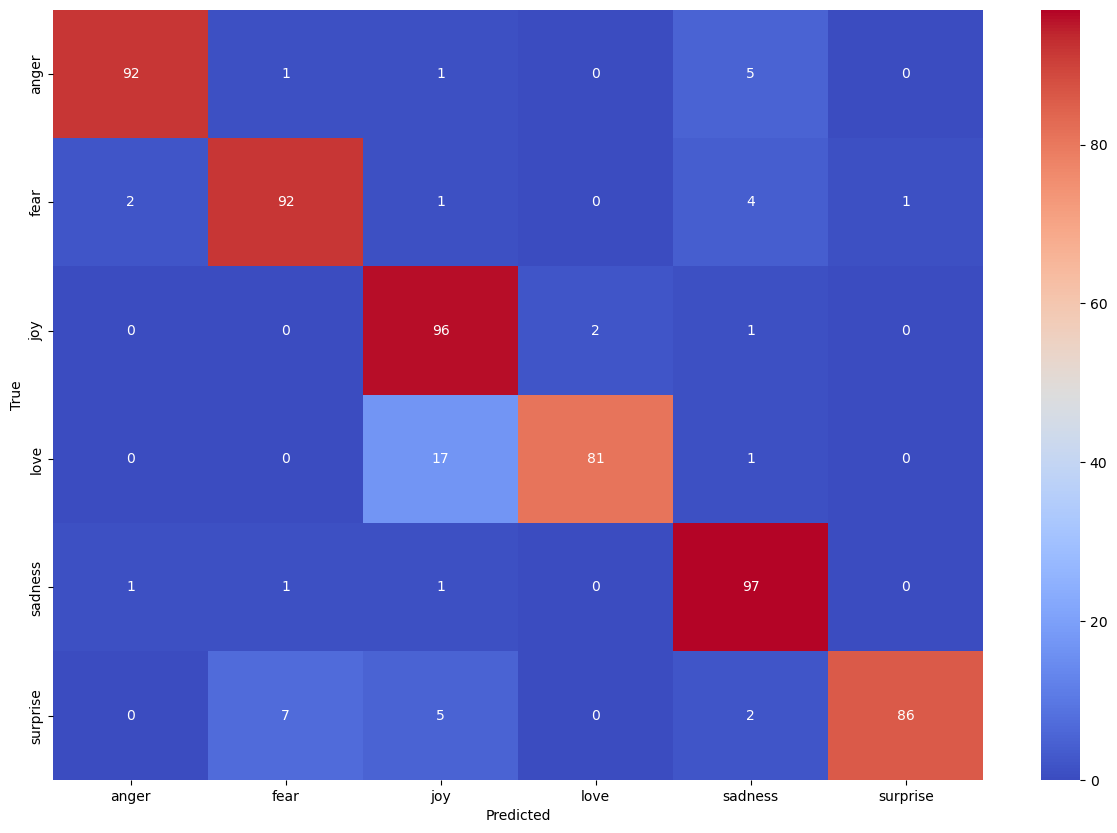

Val confusion matrix


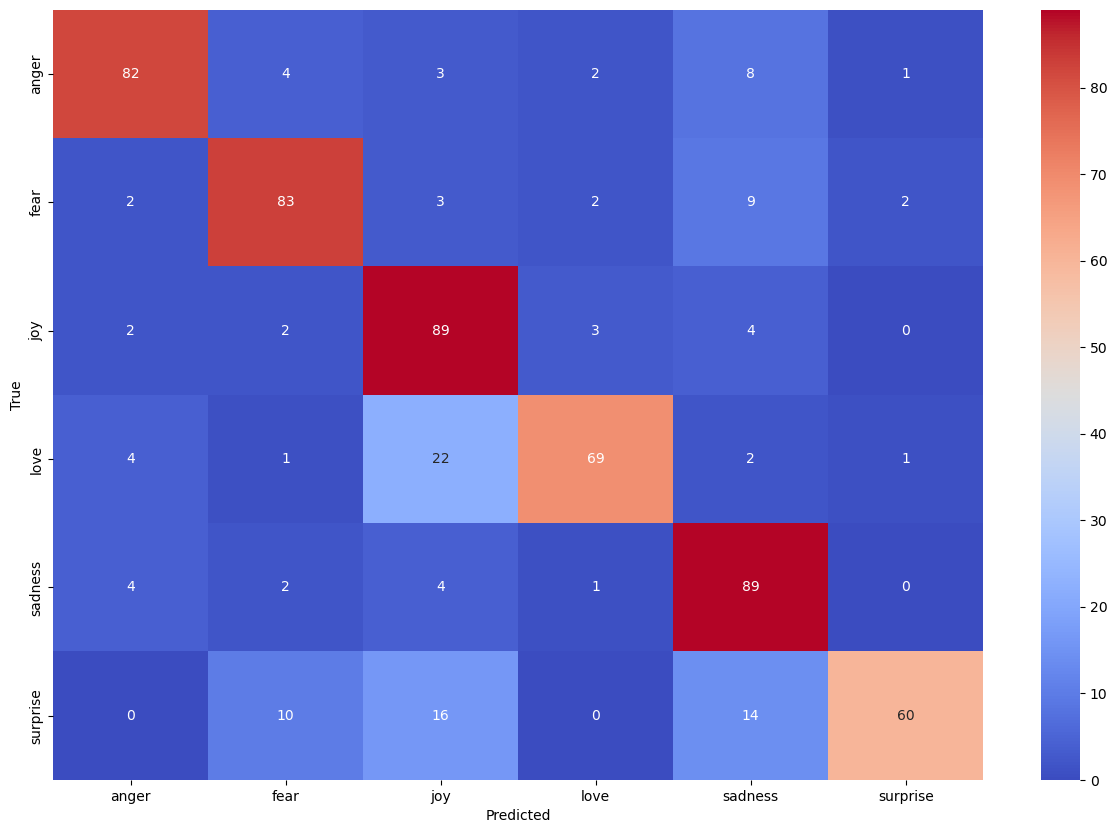

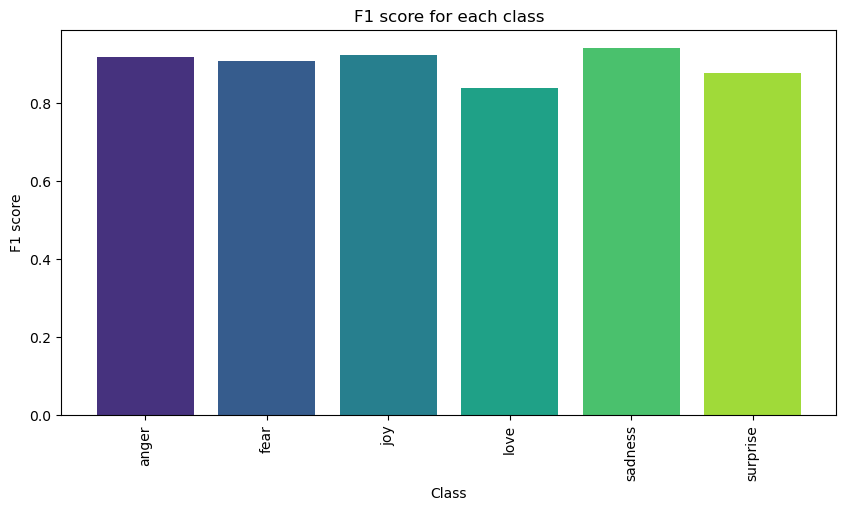

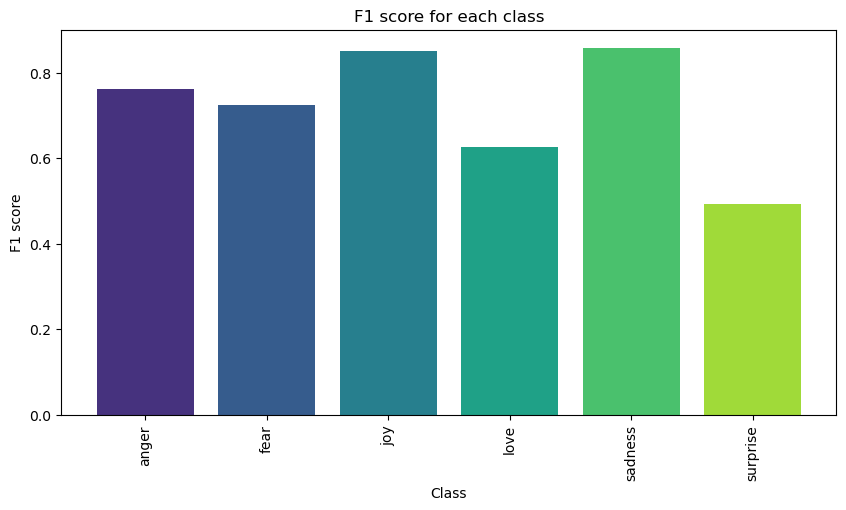

In [11]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer()),
    ('select', SelectKBest(mutual_info_classif, k=2000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
              precision    recall  f1-score   support

       anger       0.92      0.86      0.89      2159
        fear       0.91      0.82      0.86      1937
         joy       0.93      0.88      0.91      5362
        love       0.85      0.70      0.76      1304
     sadness       0.94      0.90      0.92      4666
    surprise       0.88      0.80      0.84       572

   micro avg       0.92      0.86      0.89     16000
   macro avg       0.91      0.83      0.86     16000
weighted avg       0.92      0.86      0.89     16000
 samples avg       0.84      0.86      0.85     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.92      0.80      0.86       275
        fear       0.90      0.76      0.83       212
         joy       0.93      0.86      0.89       704
        love       0.80      0.62      0.70       178
     sadness       0.92      0.89      0.91       550
    surprise       0.80      0.65      0.72        8

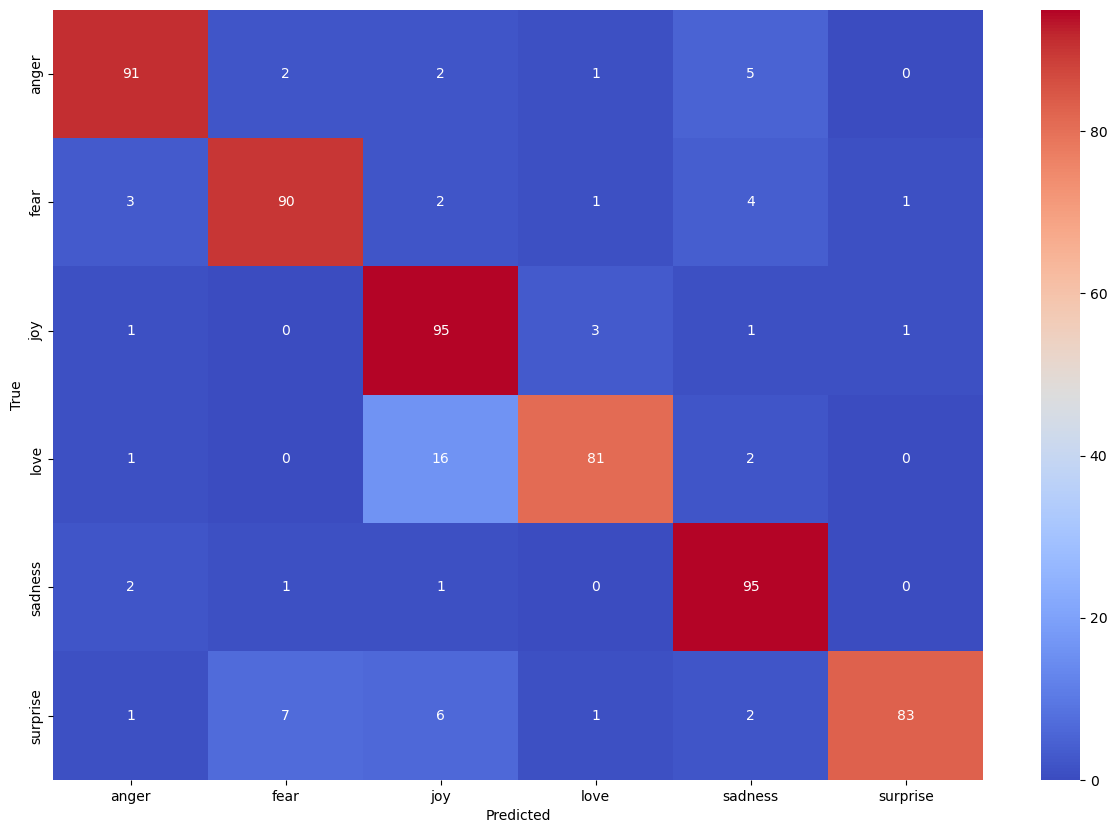

Val confusion matrix


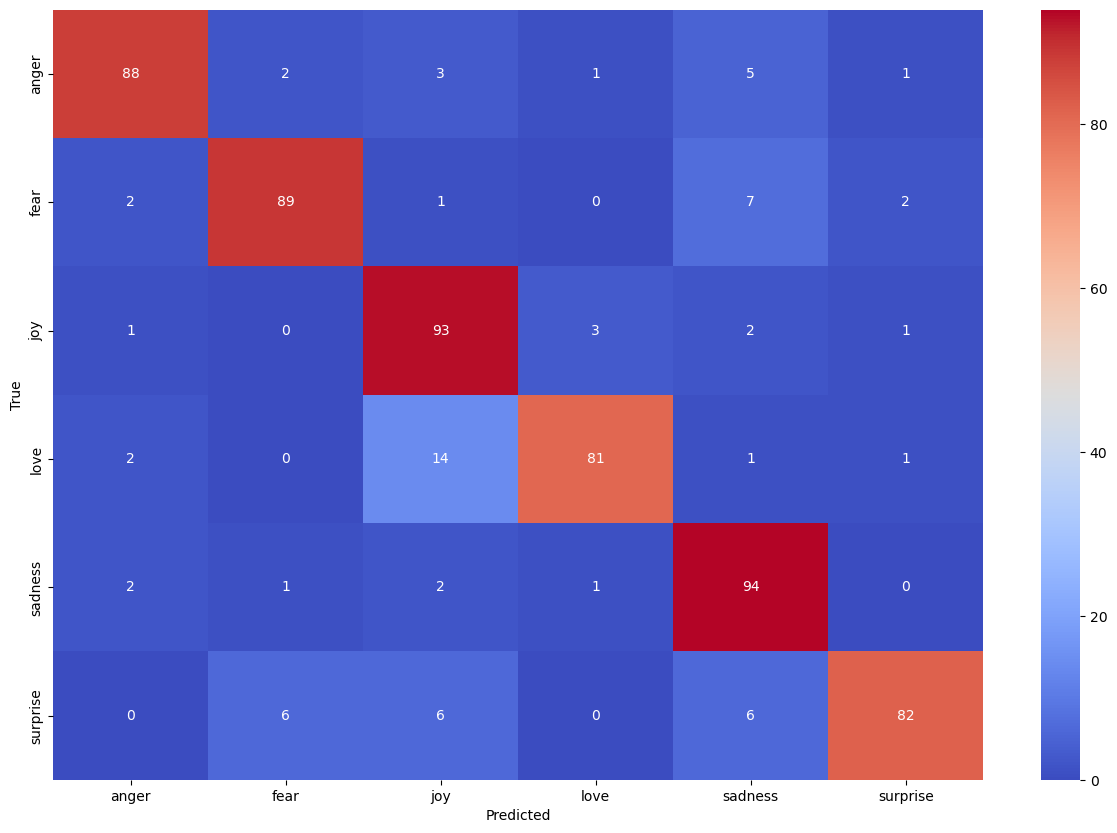

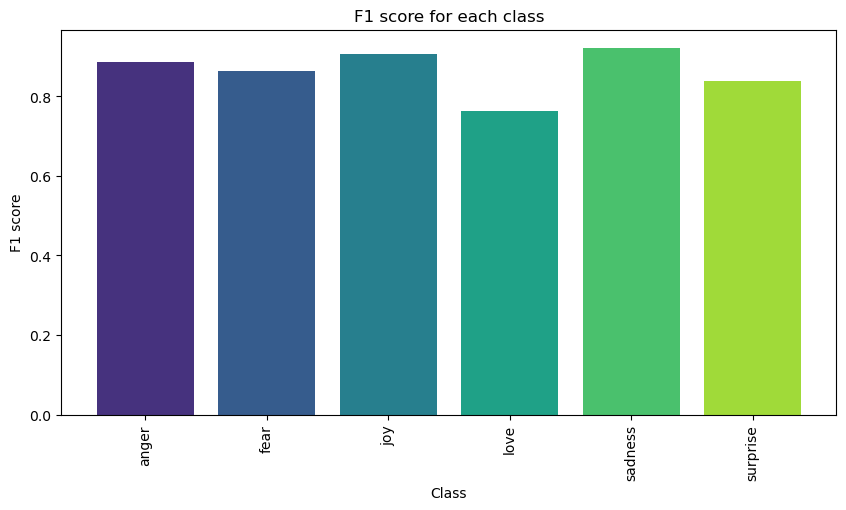

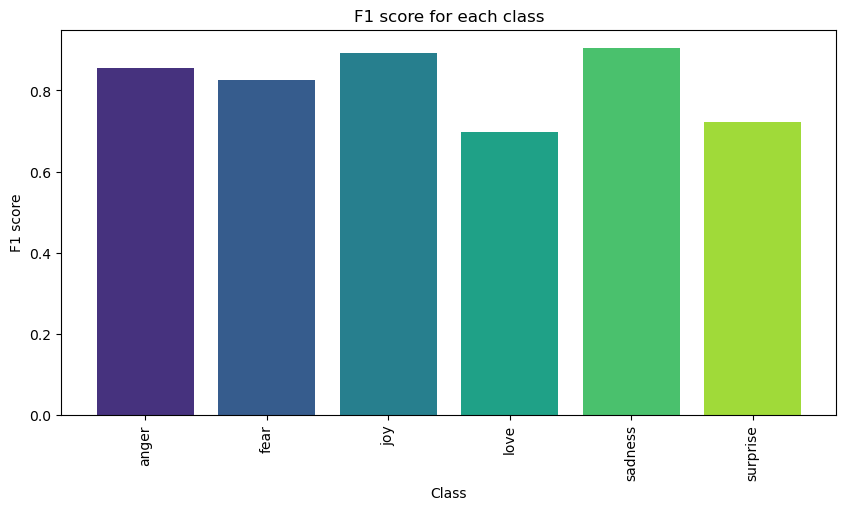

In [13]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('select', SelectKBest(mutual_info_classif, k=500)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
              precision    recall  f1-score   support

       anger       0.91      0.84      0.88      2159
        fear       0.90      0.79      0.84      1937
         joy       0.94      0.84      0.89      5362
        love       0.86      0.65      0.74      1304
     sadness       0.94      0.87      0.90      4666
    surprise       0.87      0.77      0.82       572

   micro avg       0.92      0.82      0.87     16000
   macro avg       0.90      0.79      0.84     16000
weighted avg       0.92      0.82      0.87     16000
 samples avg       0.81      0.82      0.81     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.92      0.80      0.86       275
        fear       0.86      0.77      0.82       212
         joy       0.94      0.81      0.87       704
        love       0.86      0.63      0.73       178
     sadness       0.93      0.87      0.90       550
    surprise       0.82      0.65      0.73        8

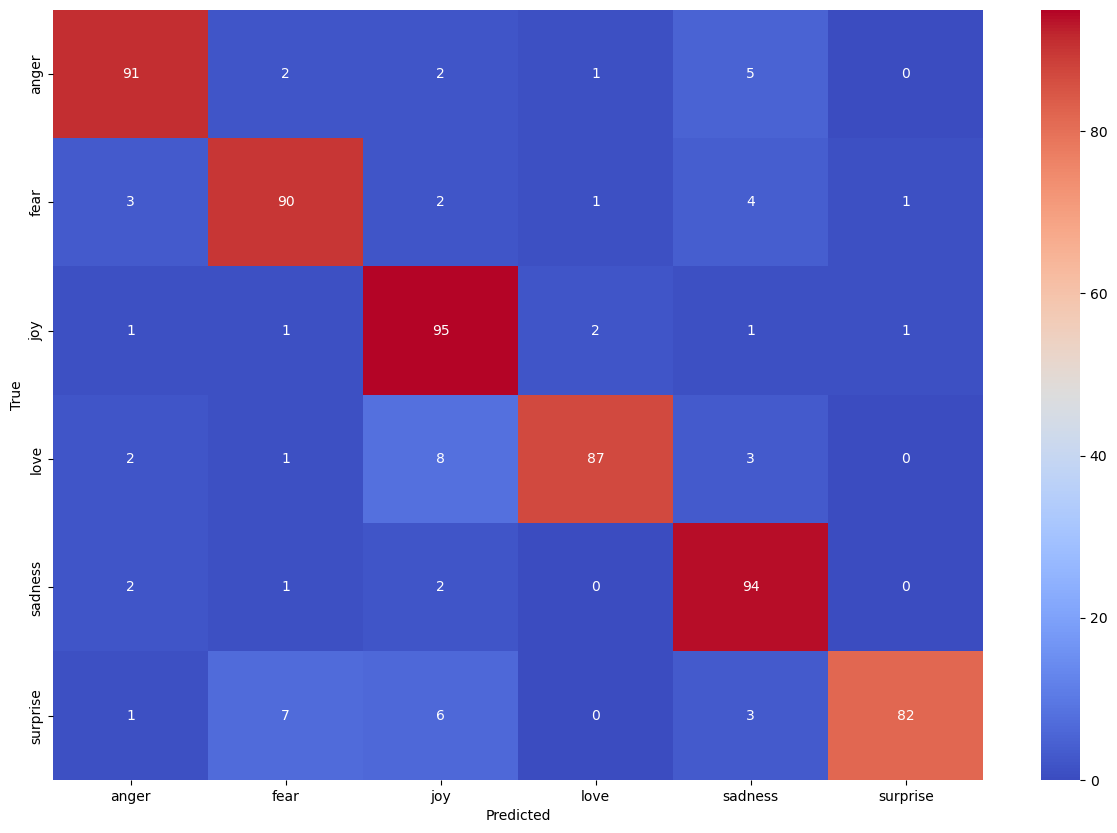

Val confusion matrix


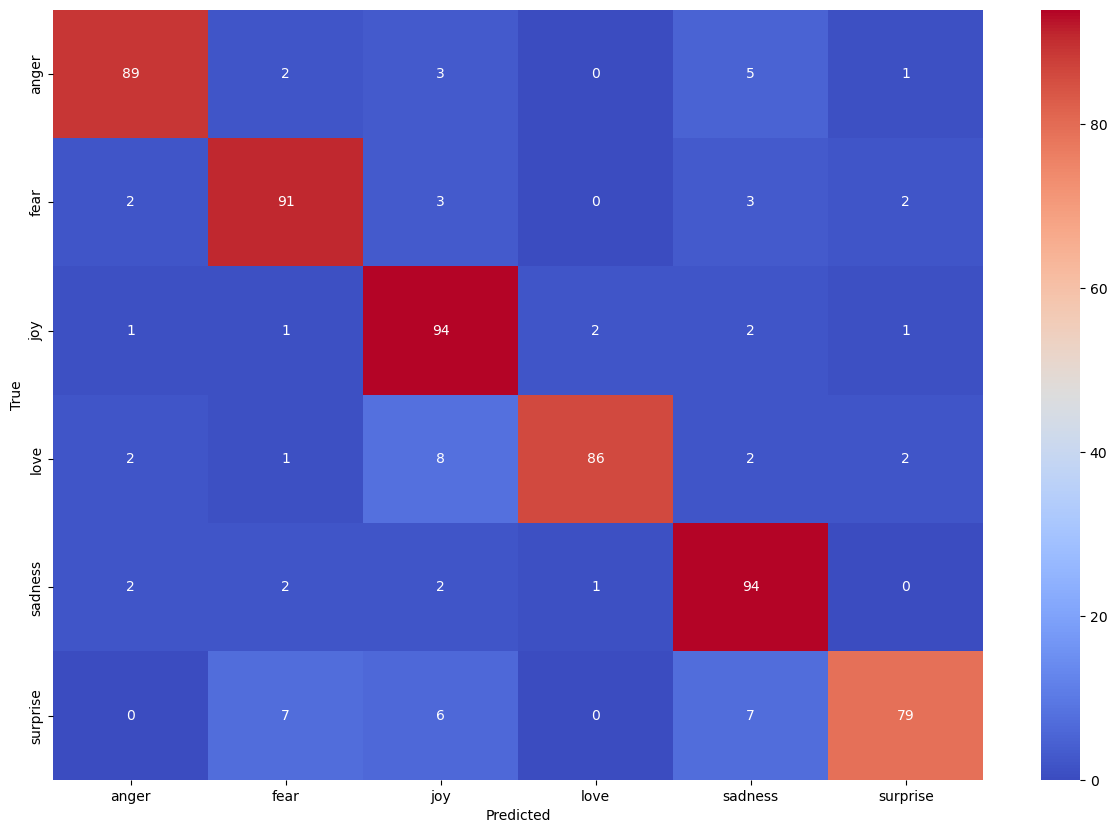

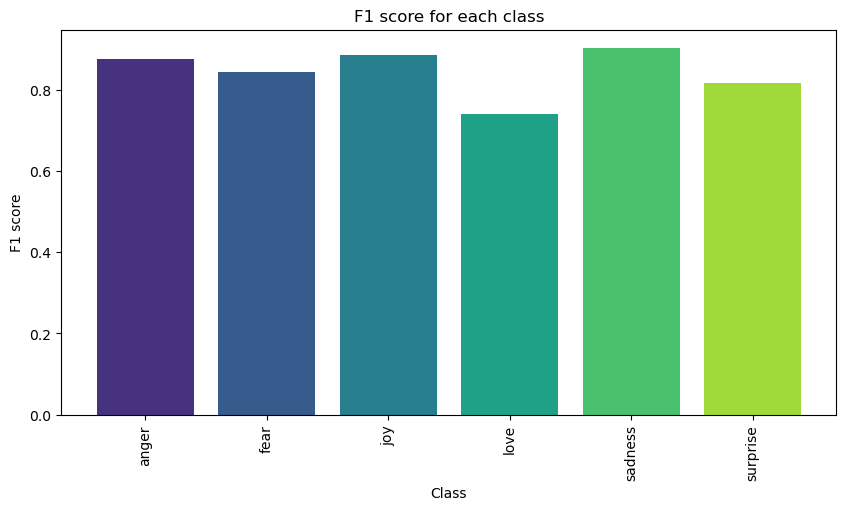

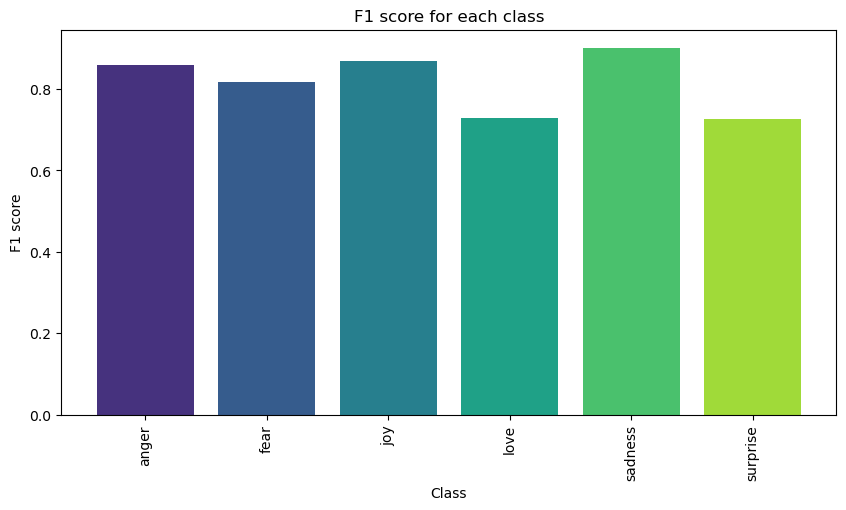

In [14]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('select', SelectKBest(mutual_info_classif, k=300)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

### Trying best on raw data to check for cleaning usefulness

In [15]:
# load raw dataset
raw_train_df, raw_val_df, raw_test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)

Train metrics
              precision    recall  f1-score   support

       anger       0.63      0.21      0.32      1567
        fear       0.78      0.47      0.58       596
         joy       0.61      0.33      0.43      1452
        love       0.80      0.71      0.75      2086
     sadness       0.70      0.35      0.47      1326
    surprise       0.73      0.33      0.46      1060

   micro avg       0.73      0.42      0.53      8087
   macro avg       0.71      0.40      0.50      8087
weighted avg       0.71      0.42      0.51      8087
 samples avg       0.08      0.08      0.08      8087

Val metrics
              precision    recall  f1-score   support

       anger       0.60      0.13      0.22       195
        fear       0.65      0.24      0.35        90
         joy       0.46      0.19      0.27       172
        love       0.75      0.64      0.69       252
     sadness       0.55      0.29      0.38       143
    surprise       0.59      0.15      0.24       12

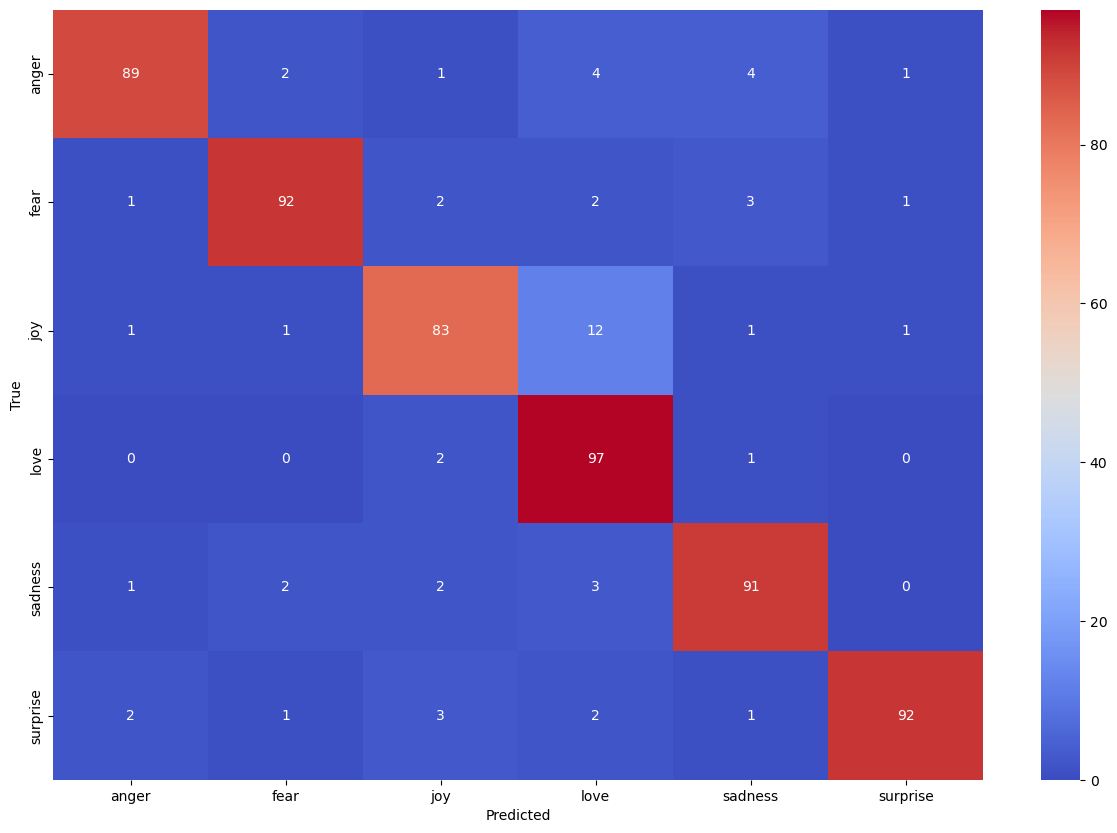

Val confusion matrix


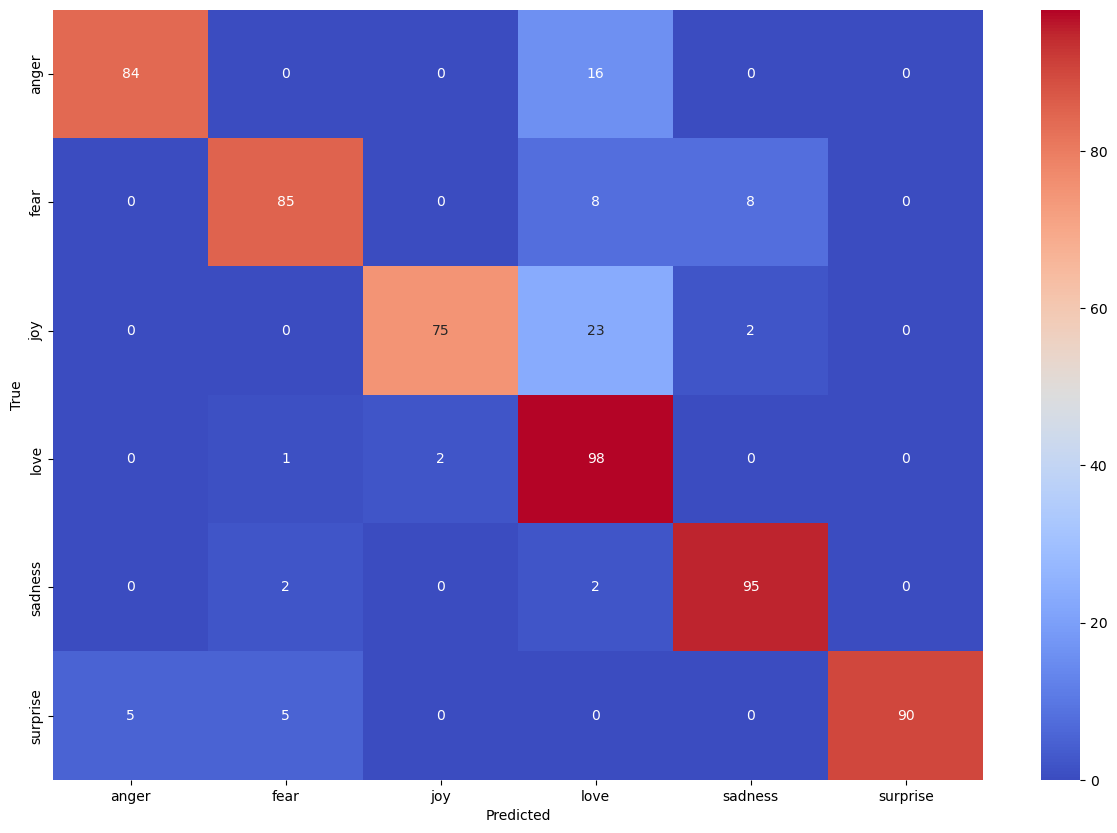

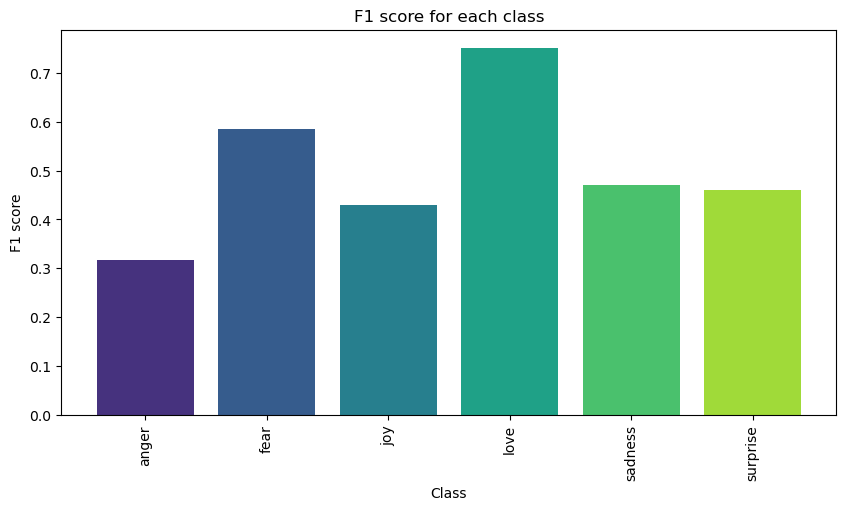

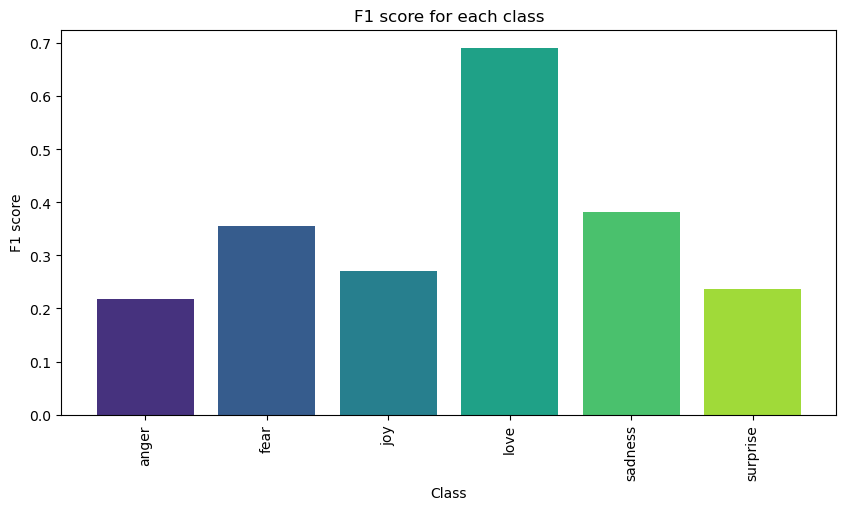

In [16]:
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('select', SelectKBest(mutual_info_classif, k=300)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(raw_train_df, raw_val_df, classifier, TEXT_COLUMN, LABELS)

in this case cleaning helped a lot in the scores

# Saving best models and test

In [17]:
CLASSIFIER_PATH = './checkpoints/TwitterData/'
if not os.path.exists(CLASSIFIER_PATH):
    os.makedirs(CLASSIFIER_PATH)
NB_CLASSIFIER_PATH = CLASSIFIER_PATH + 'nb_classifier.pkl'

Train metrics
              precision    recall  f1-score   support

       anger       0.91      0.84      0.88      2159
        fear       0.90      0.79      0.84      1937
         joy       0.94      0.84      0.89      5362
        love       0.86      0.65      0.74      1304
     sadness       0.94      0.87      0.90      4666
    surprise       0.87      0.77      0.82       572

   micro avg       0.92      0.82      0.87     16000
   macro avg       0.90      0.79      0.84     16000
weighted avg       0.92      0.82      0.87     16000
 samples avg       0.81      0.82      0.81     16000

Val metrics
              precision    recall  f1-score   support

       anger       0.92      0.80      0.86       275
        fear       0.86      0.77      0.82       212
         joy       0.94      0.81      0.87       704
        love       0.86      0.63      0.73       178
     sadness       0.93      0.87      0.90       550
    surprise       0.82      0.65      0.73        8

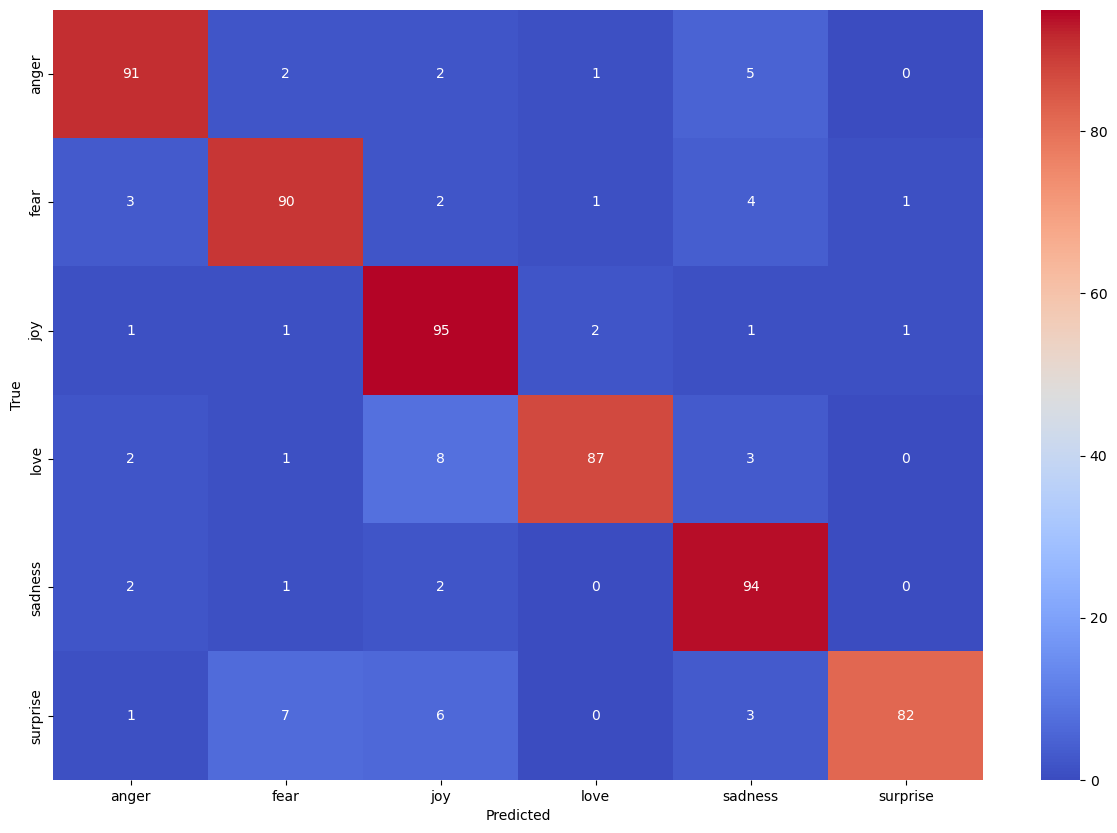

Val confusion matrix


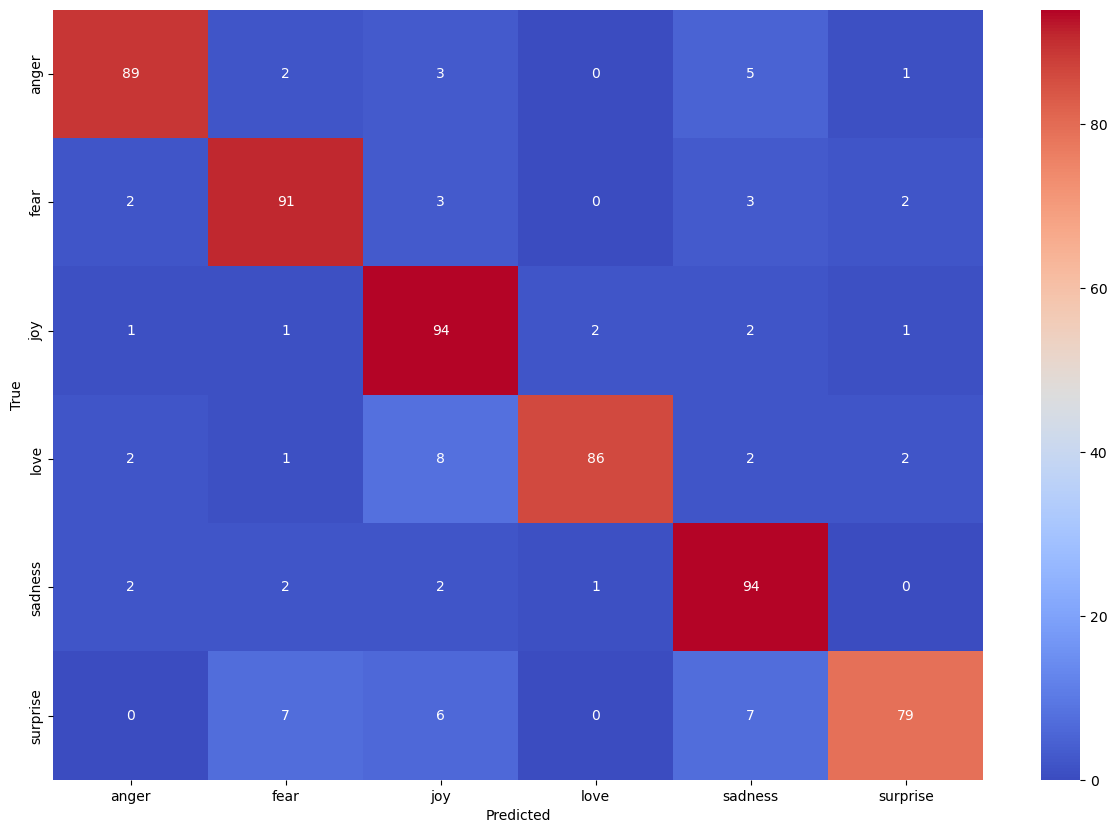

Test metrics
              precision    recall  f1-score   support

       anger       0.93      0.83      0.88       275
        fear       0.88      0.75      0.81       224
         joy       0.96      0.83      0.89       695
        love       0.76      0.56      0.64       159
     sadness       0.93      0.84      0.88       581
    surprise       0.77      0.56      0.65        66

   micro avg       0.92      0.80      0.85      2000
   macro avg       0.87      0.73      0.79      2000
weighted avg       0.92      0.80      0.85      2000
 samples avg       0.78      0.80      0.79      2000

Test confusion matrix


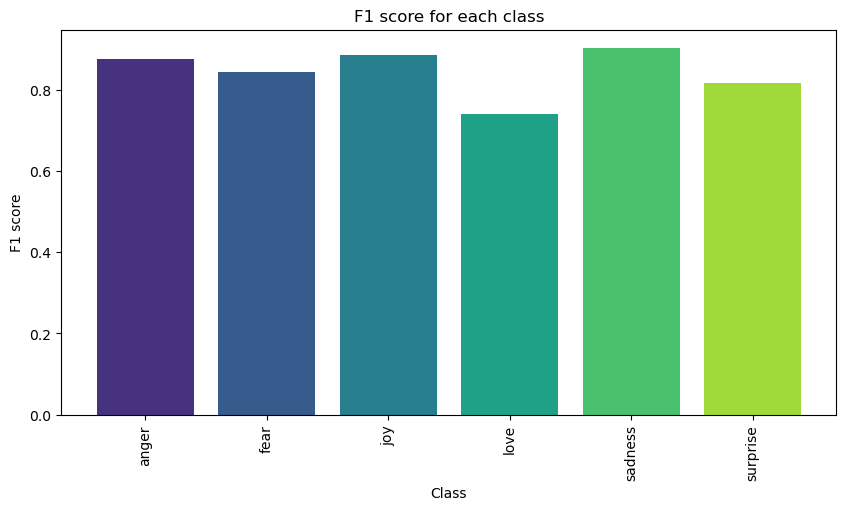

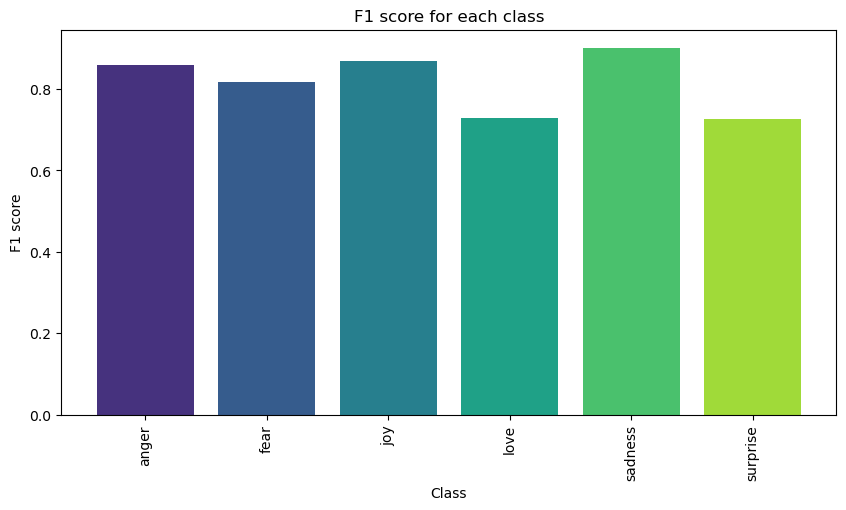

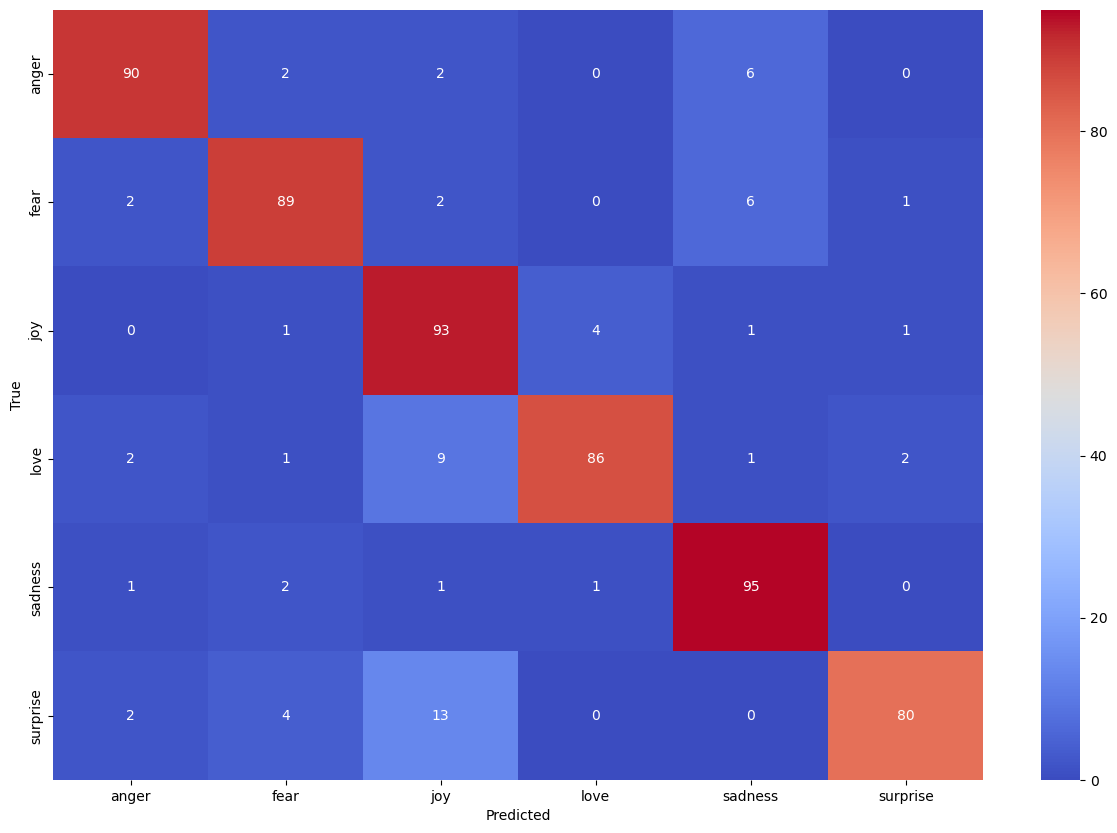

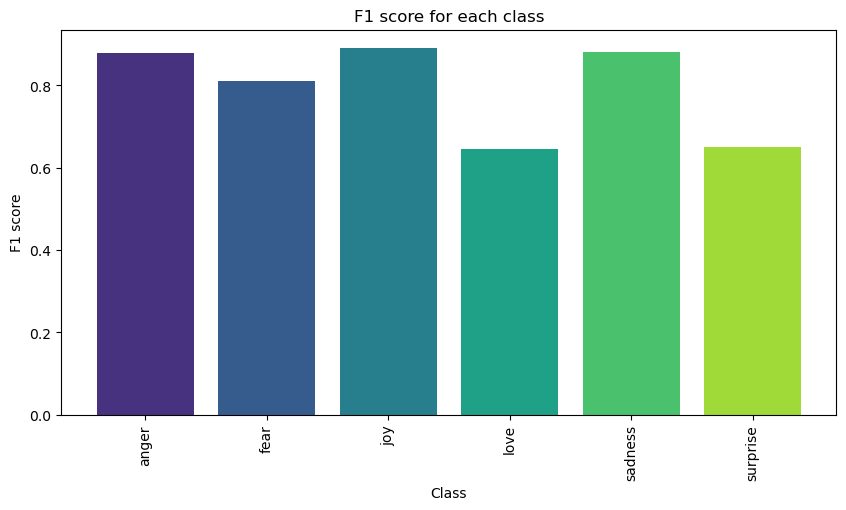

In [18]:
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words='english')),
    ('select', SelectKBest(mutual_info_classif, k=300)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

# prediction on test
predictions_test = classifier.predict(test_df[CLEAN_TEXT_COLUMN])
# calculate metrics
print("Test metrics")
print(classification_report(test_df[LABELS], predictions_test, target_names=LABELS, zero_division=0))
# plot confusion matrix
print("Test confusion matrix")
plot_multilabel_confusion_heatmap(test_df[LABELS].to_numpy(), predictions_test, LABELS, LABELS, normalize=True)
# bar plot over classes
plot_score_barplot(test_df[LABELS], predictions_test, LABELS)

# save classifier
with open(NB_CLASSIFIER_PATH, 'wb') as f:
    pickle.dump(classifier, f)